Sim info [here](https://docs.google.com/spreadsheets/d/1lfNehrNxl7ggto7P6gNRRfGNA4YKRRgE8VzDfqTWOqQ/edit#gid=1432660006) 

We use K17 Serial number 395

Current version: nside = 512 but if we need higher resolution, we need to download from [here](http://www.star.ucl.ac.uk/GowerStreetSims/) and run bornraytrace to get the kappa map! (And the e1, e2 maps)

Uniform case:

In [23]:
import os
import numpy as np
import healpy as hp
from astropy.io import fits
from astropy import units as u
from astropy.cosmology import FlatwCDM, z_at_value
from astropy import constants as const
import sys
#sys.path.insert(0, "/global/homes/q/qhang/des/")
#import ISW_functions_des as iswf
#from bornraytrace import lensing
#import des_superstructure_profile_functions as dspf
#from orphics import mpi,stats
#import argparse
import pylab as pl

In [2]:
simroot = "/global/cfs/cdirs/des/mgatti/Dirac_mocks/runsK/run017/"

In [3]:
# set up cosmology:
run_X = 'K'
run_n = 17
fname=f"/global/homes/m/mgatti/Mass_Mapping/peaks/params_run_1_Niall_{run_X}.txt"
cosmodata = np.loadtxt(fname, delimiter=',')
Om0 = cosmodata[run_n-1,0]
w0 = cosmodata[run_n-1,2]
Ob0 = cosmodata[run_n-1,3]
h0=cosmodata[run_n-1,4]
cosmo = FlatwCDM(H0=h0*100, Om0=Om0,w0=w0,Ob0=Ob0,Tcmb0=2.73)
print(cosmo)

FlatwCDM(H0=70.0 km / (Mpc s), Om0=0.279, w0=-1.0, Tcmb0=2.73 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=0.046)


In [4]:
Ob0

0.046

In [5]:
sigma8=0.82
ns=0.97

In [6]:
print(Ob0*h0**2)
print((Om0-Ob0)*h0**2)

0.022539999999999998
0.11417000000000001


In [7]:
import pyccl as ccl
ccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = True
cosmo_ccl = ccl.Cosmology(Omega_c = Om0-Ob0, Omega_b = Ob0, h = h0, sigma8 = sigma8, n_s = ns)

In [8]:
# load z_values
z_values=np.loadtxt(simroot + "z_values.txt", delimiter=',')
z_values_index = z_values[:,0]
z_values_bin_max = z_values[:,1]
z_values_bin_min = z_values[:,2]
z_bin_edges = np.append(z_values_bin_max, z_values_bin_min[-1])
z_bin = (z_bin_edges[1:] + z_bin_edges[:-1])/2.

In [9]:
dz=z_values_bin_max-z_values_bin_min

In [10]:
nside=512
lmax=1000
pixwin = hp.pixwin(nside,lmax=lmax)**2

In [11]:
# load mask in nside=512
root="/pscratch/sd/q/qhang/glass_mock/catalog_info/mask/"
mask=hp.read_map(root+"wfd_footprint_nvisitcut_500_nside_128-ebv-0.2-1024.fits")
mask=hp.ud_grade(mask,512)
fsky=np.mean(mask)
print(fsky)
# compute the sky area in terms of armin:
area_pix = hp.nside2pixarea(512, degrees=True)*60**2 # arcmin^2
total_area = np.sum(mask*area_pix)
print(total_area)

0.41963705
62320550.0


In [32]:
#Ngal_lens=np.array([0.26926969063742207, 0.4155229311672192, 0.3868262896466897,
#                     0.39164517236812874, 0.20673591618054046])
# arcmin ^-2

Ngal_lens=np.array([3.93, 6.08, 5.66, 5.71, 3.03])# arcmin ^-2

In [47]:
# load the lens redshift distribution:
# bin 1:
USESHELL={}
USEINDEX={}
NZ_LENS={}
COUNTS={}
MEANZ={}

for lens_bin in range(5):

    #lens_bin=0
    root="/pscratch/sd/q/qhang/glass_mock/catalog_info/lsst-y3-fzb/"
    fin = np.loadtxt(root+f"NofZ-lens-tomo-{lens_bin}-fzb.dat")
    finzbin = fin[:,0]
    finzz = (finzbin[1:]+ finzbin[:-1])/2.
    finnz = fin[:-1,1]
    N=Ngal_lens[lens_bin]*total_area

    # normalise to nz
    counts = finnz/np.sum(finnz)/(finzbin[1:]-finzbin[:-1]) # notice here dz is constant
    # interpolate the values at z_bin:
    counts = np.interp(z_values_bin_max[::-1], finzz, counts, left=0,right=0)
    # normalise by dz
    counts=counts*(z_values_bin_max[::-1] - z_values_bin_min[::-1])
    counts = counts/np.sum(counts)*N # normalise
    counts = counts[::-1] # this is the number of objects per bin in the same order as the index
    
    # compute mean redshift too:
    meanz=np.sum(z_bin*counts)/np.sum(counts)
    print("N", N, "meanz", meanz)

    # n(z) for lens
    nz_lens=counts/np.sum(counts)/(z_bin_edges[:-1]-z_bin_edges[1:])
    # define which shells are used
    useshell = np.where(counts>0)[0] #(0-99 based)
    useindex = z_values_index[useshell].astype(int)
    #print("The following shells (0-99) are used for lens: ",useshell)
    
    USESHELL[lens_bin]=useshell
    USEINDEX[lens_bin]=useindex
    NZ_LENS[lens_bin]=nz_lens
    COUNTS[lens_bin]=counts
    MEANZ[lens_bin]=meanz

N 244919769.36 meanz 0.3162781356362478
N 378908956.16 meanz 0.5002978709756103
N 352734324.32 meanz 0.7031148937336513
N 355850351.92 meanz 0.8900926423078465
N 188831272.56 meanz 1.0809513401248552


In [48]:
COUNTS_UD=COUNTS.copy()

(0.0, 3.0)

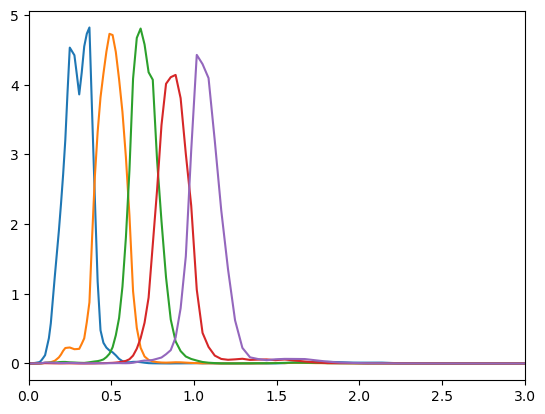

In [15]:
for ii in range(5):
    counts=COUNTS[ii]
    pl.plot(z_bin, counts/sum(counts)/dz)
pl.xlim([0,3])

Uniform, delta map:

In [90]:
# deltamap for uniform case!
# this is just to make the galaxy maps reproducible
savedir="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"

for lens_bin in range(5):
    
    nz_lens = COUNTS[lens_bin]/sum(COUNTS[lens_bin])
    useshell = USESHELL[lens_bin]
    useindex = USEINDEX[lens_bin]

    galmap_inmask = 0
    for ii,index in enumerate(useindex):
        dens = hp.read_map(simroot + f"lens_{index}_512.fits")
        galmap_inmask += dens*nz_lens[useshell][ii]

    # save galmap
    fname=savedir+f"deltamap-lens-tomo-{lens_bin}-nside-512.fits"
    hp.write_map(fname, galmap_inmask*mask, overwrite=True)
    print("Written: ", fname)

setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-lens-tomo-0-nside-512.fits


setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-lens-tomo-1-nside-512.fits


setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-lens-tomo-2-nside-512.fits


setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-lens-tomo-3-nside-512.fits


setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-lens-tomo-4-nside-512.fits


Uniform, galaxy map:

In [16]:
# now compute galaxy number per pixel:
# generate lens galaxy map:
bias=1
Npix = np.sum(mask)
np.random.seed(1234)
# this is just to make the galaxy maps reproducible
savedir="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"

for lens_bin in range(5):
    
    counts = COUNTS[lens_bin]
    useshell = USESHELL[lens_bin]
    useindex = USEINDEX[lens_bin]
    
    Ngal_perpix = counts[useshell]/Npix

    galmap_inmask = 0
    for ii,index in enumerate(useindex):
        dens = hp.read_map(simroot + f"lens_{index}_512.fits")
        exp_Ngal = Ngal_perpix[ii]*(1+bias*dens)
        exp_Ngal = exp_Ngal[mask.astype(bool)]
        # set anything smaller than 0 to 0
        exp_Ngal[exp_Ngal<0]=0
        galmap_inmask += np.random.poisson(lam=exp_Ngal)

    galmap = np.zeros(len(mask))
    galmap[mask.astype(bool)] = galmap_inmask

    # save galmap
    fname=savedir+f"galmap-lens-tomo-{lens_bin}-nside-512.fits"
    hp.write_map(fname, galmap, overwrite=True)
    print("Written: ", fname)

setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/galmap-lens-tomo-0-nside-512.fits


setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/galmap-lens-tomo-1-nside-512.fits


setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/galmap-lens-tomo-2-nside-512.fits


setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/galmap-lens-tomo-3-nside-512.fits


setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/galmap-lens-tomo-4-nside-512.fits


In [17]:
galmap={}

savedir="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
for lens_bin in range(5):
    fname=savedir+f"galmap-lens-tomo-{lens_bin}-nside-512.fits"
    galmap[lens_bin]=hp.read_map(fname)

In [18]:
shotnoise=np.zeros(5)
for ii in range(5):
    shotnoise[ii]=4*np.pi*fsky/sum(galmap[ii])

In [19]:
print(shotnoise)

[2.14608250e-08 1.39388165e-08 1.49310243e-08 1.48179262e-08
 2.79369541e-08]


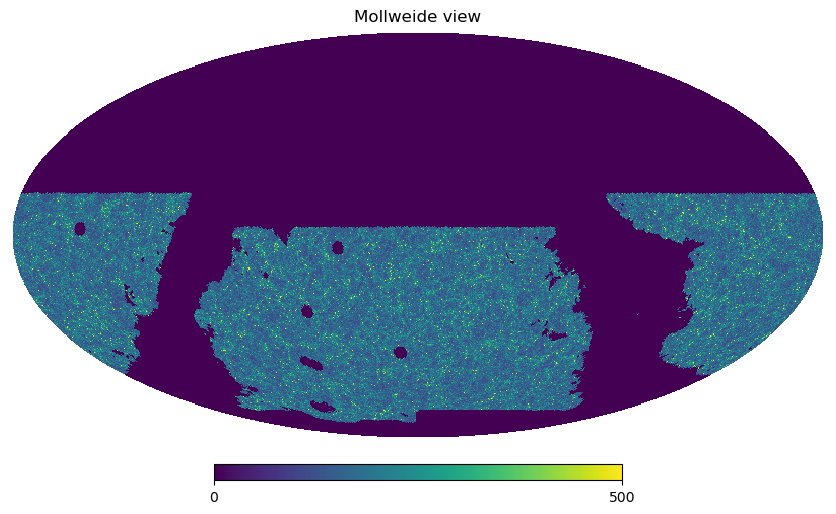

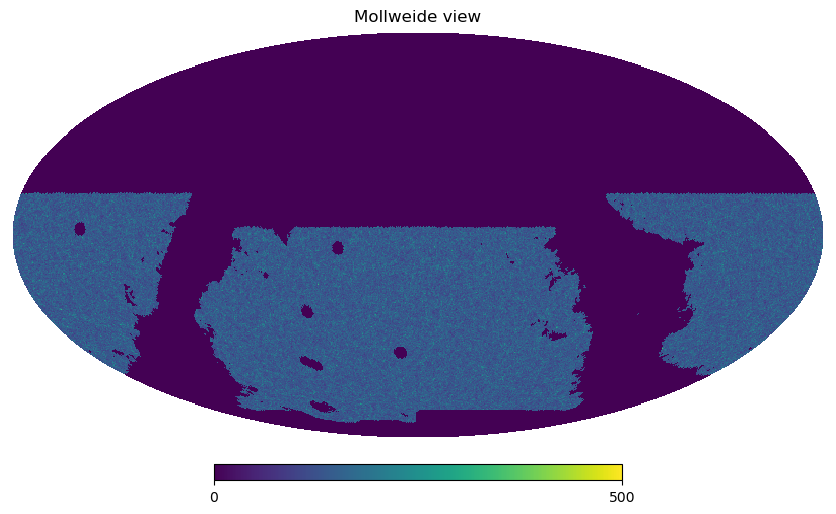

In [21]:
hp.mollview(galmap[0],max=500)
hp.mollview(galmap[4],max=500)

In [22]:
clgg = np.zeros((1001, 5))
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
for ii in range(5):
    # now let's check fitting ccl theory / camb theory!
    delta = (galmap[ii]/(sum(galmap[ii])/sum(mask))-1)*mask
    clgg[:,ii] = hp.anafast(delta,lmax=1000)/fsky

fname = root+"clgg-pseudo-cl-w-fsky-nside-512.txt"
np.savetxt(fname, clgg)

In [94]:
densmap={}

savedir="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
for lens_bin in range(5):
    fname=savedir+f"deltamap-lens-tomo-{lens_bin}-nside-512.fits"
    densmap[lens_bin]=hp.read_map(fname)

In [95]:
clmm = np.zeros((1001, 5))
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
for ii in range(5):
    # now let's check fitting ccl theory / camb theory!
    delta = densmap[ii]*mask
    clmm[:,ii] = hp.anafast(delta,lmax=1000)/fsky

fname = root+"clmm-pseudo-cl-w-fsky-nside-512.txt"
np.savetxt(fname, clmm)

In [96]:
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
fname = root+"clgg-pseudo-cl-w-fsky-nside-512.txt"  
clgg = np.loadtxt(fname)

fname = root+"clmm-pseudo-cl-w-fsky-nside-512.txt"  
clmm = np.loadtxt(fname)

In [35]:
root="/pscratch/sd/q/qhang/glass_mock/catalog_info/lsst-y3-fzb/"
ell=np.arange(1,3*nside)
clth = np.zeros((3*nside,5))
for lens_bin in range(5):
    
    #fin = np.loadtxt(root+f"NofZ-lens-tomo-{lens_bin}-fzb.dat")
    #finzbin = fin[:,0]
    #finzz = (finzbin[1:]+ finzbin[:-1])/2.
    #finnz = fin[:-1,1]
    
    # try ccl:
    counts = COUNTS[lens_bin]
    nz = counts/np.sum(counts)/dz
    clu1 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(z_bin[::-1], nz[::-1]), 
                                          bias=(z_bin[::-1],np.ones(len(finzz))))

    tmp=ccl.angular_cl(cosmo_ccl, clu1, clu1, ell)
    clth[:,lens_bin] = np.append(0, tmp)
    
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
fname = root+"clgg-theory-z_bin-nside-512.txt"
np.savetxt(fname, clth)

In [36]:
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
fname = root+"clgg-theory-z_bin-nside-512.txt"    
clth = np.loadtxt(fname)

In [43]:
# modify theory:
clth_obs = np.zeros((1001,5))
for ii in range(5):
    clth_obs[:,ii] = (clth[:1001,ii]*pixwin)#+shotnoise[ii]
    #clth_obs[:,ii] = (clth[:1001,ii]+shotnoise[ii])*pixwin

In [76]:
def fit_shotnoise(param, data, model, pshot):
    return np.sum(abs(data/(model+param*pshot)-1))

In [77]:
shotnoise

array([2.14608250e-08, 1.39388165e-08, 1.49310243e-08, 1.48179262e-08,
       2.79369541e-08])

In [81]:
from scipy.optimize import minimize

new_shot=[]
for ii in range(5):
    x0=1.2
    res = minimize(fit_shotnoise, x0, args=(clgg[600:,ii], clth_obs[600:,ii], shotnoise[ii]), tol=1e-10)
    new_shot.append(res.x[0]*shotnoise[ii])
    print(res.x[0])
print(new_shot)

for ii in range(5):
    ratio = clgg[:,ii]/(clth_obs[:,ii]+new_shot[ii])
    ratio[0:2] = 0
    mean = np.mean(ratio)
    std = np.std(ratio)/np.sqrt(1000)
    print(mean, std)

1.799741707666399
1.8210618937090812
1.641374020845469
1.4403160709140577
1.201682886172696
[3.862394178701377e-08, 2.538344765781688e-08, 2.4507395444259033e-08, 2.1342497199973858e-08, 3.357135958745967e-08]
1.0033542784857687 0.004318011002342694
0.9954430160248599 0.0028809479549996462
1.0037531275682723 0.004857761059233636
1.0026449439453062 0.005349261399163584
1.0068662771158263 0.005652264837293483


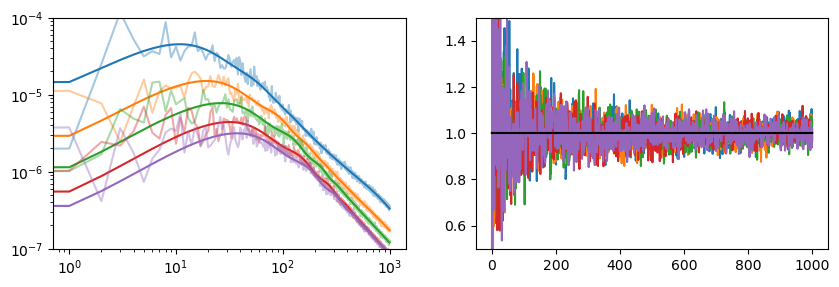

In [80]:
# plot all of them:
fig,axarr=pl.subplots(1,2,figsize=[10,3])
for ii in range(5):
    pl.sca(axarr[0])
    
    pl.loglog(clgg[:,ii],alpha=0.4)
    pl.loglog(clth_obs[:,ii]+new_shot[ii],color=f'C{ii}')
    pl.ylim([1e-7,1e-4])
    
    pl.sca(axarr[1])
    pl.plot(clgg[:,ii]/(clth_obs[:,ii]+new_shot[ii]))
    #pl.plot(cls["W1xW1"])
    pl.plot([1,1000],[1,1],'k-')
    pl.ylim([0.5,1.5])

/tmp/ipykernel_1276784/3139822734.py:11: RuntimeWarning: divide by zero encountered in divide
  pl.plot(clmm[:,ii]/(clth_obs[:,ii]))


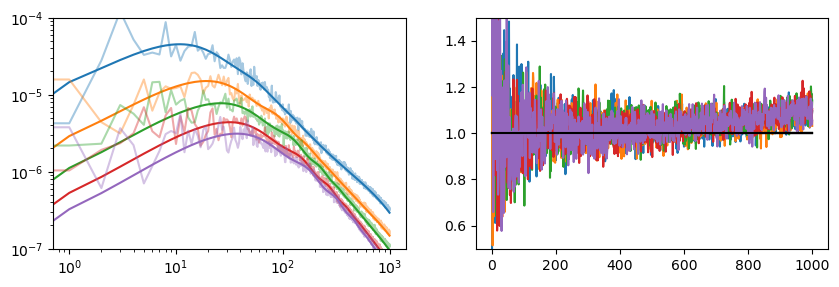

In [99]:
# plot all of them:
fig,axarr=pl.subplots(1,2,figsize=[10,3])
for ii in range(5):
    pl.sca(axarr[0])
    
    pl.loglog(clmm[:,ii],alpha=0.4)
    pl.loglog(clth_obs[:,ii],color=f'C{ii}')
    pl.ylim([1e-7,1e-4])
    
    pl.sca(axarr[1])
    pl.plot(clmm[:,ii]/(clth_obs[:,ii]))
    #pl.plot(cls["W1xW1"])
    pl.plot([1,1000],[1,1],'k-')
    pl.ylim([0.5,1.5])

# Build source maps:

we will generate source counts as well because we will need it for errors

let's generate the weighted kappa maps first and check with theory:


In [368]:
NZ_SOURCE={}
SOURCE_SHELL={}
for tomo_source in range(5):
    #tomo_source=2
    # normalise to nz
    root="/pscratch/sd/q/qhang/glass_mock/catalog_info/lsst-y3-fzb/"
    fin = np.loadtxt(root+f"NofZ-source-tomo-{tomo_source}-fzb.dat")
    finzbin = fin[:,0]
    finzz = (finzbin[1:]+ finzbin[:-1])/2.
    finnz = fin[:-1,1]

    nz_source = finnz/np.sum(finnz)/(finzbin[1:]-finzbin[:-1]) # notice here dz is constant
    # interpolate the values at z_bin:
    nz_source = np.interp(z_values_bin_max[::-1], finzz, nz_source,left=0,right=0)
    nz_source=nz_source*(z_values_bin_max[::-1] - z_values_bin_min[::-1])
    nz_source = nz_source/np.sum(nz_source) # normalise
    nz_source=nz_source[::-1] # (0-99 base, same ordering as index)

    source_shell = np.where(nz_source>0)[0]
    #print("The following shells (0-99) are used for source: ",source_shell)
    
    NZ_SOURCE[tomo_source]=nz_source
    SOURCE_SHELL[tomo_source]=source_shell

(0.0, 3.0)

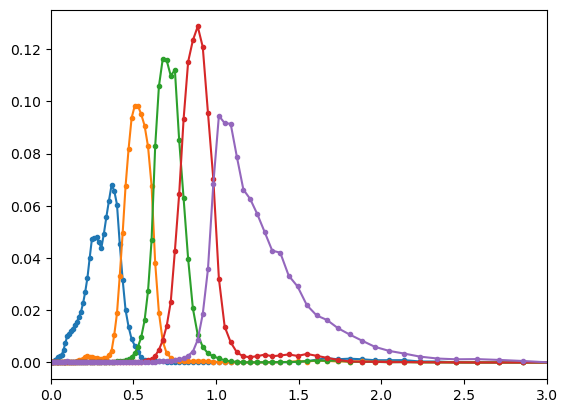

In [34]:
for ii in range(5):
    nz_source=NZ_SOURCE[ii]
    pl.plot(z_bin, nz_source,'.-')
pl.xlim([0,3])

In [28]:
def gk_inv(K, KB, nside, lmax):
    """
    Performs inverse spin transformation on convergence and curl components.

    Args:
        K (array): Convergence map.
        KB (array): Curl/B-mode map.
        nside (int): HEALPix nside parameter.
        lmax (int): Maximum multipole moment.

    Returns:
        tuple: Reconstructed E-mode and B-mode maps.
    """
    alms = hp.map2alm(K, lmax=lmax, pol=False)
    ell, emm = hp.Alm.getlm(lmax=lmax)
    kalmsE = alms / (1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5)
    kalmsE[ell == 0] = 0.0
    alms = hp.map2alm(KB, lmax=lmax, pol=False)
    ell, emm = hp.Alm.getlm(lmax=lmax)
    kalmsB = alms / (1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5)
    kalmsB[ell == 0] = 0.0
    _, e1t, e2t = hp.alm2map([kalmsE, kalmsE, kalmsB], nside=nside, lmax=lmax, pol=True)
    return e1t, e2t

In [19]:
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
for ii in range(5):
    source_shell = SOURCE_SHELL[ii]
    nz_source = NZ_SOURCE[ii]
    
    kappa_source = 0
    for kk, shell in enumerate(source_shell):
        kappa = hp.read_map(simroot + f"kappa_{shell}_512.fits")
        kappa_source += kappa*nz_source[shell] # invert the order for nz_source so it goes from 0-99
    # also convert to e1, e2:
    e1, e2 = gk_inv(kappa_source, np.zeros(len(kappa_source)), nside, 3*nside-1)

    # save map
    fname=root+f"kappa-true-tomo-{ii}-nside-512.fits"
    hp.write_map(fname, [kappa_source, e1, e2], overwrite=True)
    print("Written: ", fname)

/tmp/ipykernel_1657124/912852787.py:16: RuntimeWarning: divide by zero encountered in divide
  kalmsE = alms / (1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5)
/tmp/ipykernel_1657124/912852787.py:16: RuntimeWarning: invalid value encountered in divide
  kalmsE = alms / (1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5)
/tmp/ipykernel_1657124/912852787.py:20: RuntimeWarning: divide by zero encountered in divide
  kalmsB = alms / (1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5)
/tmp/ipykernel_1657124/912852787.py:20: RuntimeWarning: invalid value encountered in divide
  kalmsB = alms / (1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5)
setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/kappa-true-tomo-0-nside-512.fits


setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/kappa-true-tomo-1-nside-512.fits


setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/kappa-true-tomo-2-nside-512.fits


setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/kappa-true-tomo-3-nside-512.fits


setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/kappa-true-tomo-4-nside-512.fits


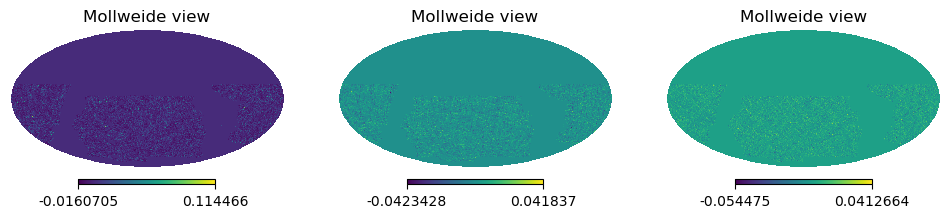

In [52]:
fig,axarr=pl.subplots(1,3,figsize=[12,3])
pl.sca(axarr[0])
hp.mollview(kappa_source*mask,hold=True)
pl.sca(axarr[1])
hp.mollview(e1*mask,hold=True)
pl.sca(axarr[2])
hp.mollview(e2*mask,hold=True)

In [82]:
lensing={}
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"

for ii in range(5):
    fname=root+f"kappa-true-tomo-{ii}-nside-512.fits"
    lensing[ii] = hp.read_map(fname,field=[0,1,2])
    #lensing = [np.zeros(len(mask)),lensing[0],lensing[1]]

In [32]:
clkk = np.zeros((1001,15))
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"

kk=0
for ii in range(5):
    for jj in range(5):
        if ii>=jj:
            clkk[:,kk] = hp.anafast(lensing[ii],lensing[jj], lmax=1000)[1]
            kk+=1         

# save:
fname = root+"clkk-full-sky-nside-512.txt"
np.savetxt(fname, clkk)
print("Written: ", fname)

Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/clkk-full-sky-nside-512.txt 


In [363]:
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
clkk = np.loadtxt(root+"clkk-full-sky-nside-512.txt")

In [51]:
root="/pscratch/sd/q/qhang/glass_mock/catalog_info/lsst-y3-fzb/"
NZ_SOURCE_uniform={}
for tomo_source in range(5):
    fin = np.loadtxt(root+f"NofZ-source-tomo-{tomo_source}-fzb.dat")
    finzbin = fin[:,0]
    #finzz = (finzbin[1:]+ finzbin[:-1])/2.
    finzz = finzbin[1:]
    finnz = fin[:-1,1]
    
    NZ_SOURCE_uniform[tomo_source]=np.c_[finzz, finnz]

In [53]:
NZ_SOURCE_uniform_UD=NZ_SOURCE_uniform.copy()

In [360]:
# compute theory
ell=np.arange(1,3*nside)
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"

clth=np.zeros((3*nside, 15))
zsamp = np.linspace(0,3,300)
kk=0
for ii in range(5):
    nz =  NZ_SOURCE_uniform[ii]
    nzsamp = np.interp(zsamp, nz[:,0], nz[:,1])
    she1 = ccl.WeakLensingTracer(cosmo_ccl, dndz=(zsamp, nzsamp))
    for jj in range(5):
        if ii>=jj:
            
            nz =  NZ_SOURCE_uniform[jj] # no normalization
            nzsamp = np.interp(zsamp, nz[:,0], nz[:,1])
            she2 = ccl.WeakLensingTracer(cosmo_ccl, dndz=(zsamp, nzsamp))

            tmp=ccl.angular_cl(cosmo_ccl, she1, she2, ell)
            
            clth[:,kk] = np.append(0, tmp)
            kk+=1
# save:
fname = root+"clkk-theory-nside-512.txt"
np.savetxt(fname, clth)
print("Written: ", fname)

Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/clkk-theory-nside-512.txt


In [369]:
# compute theory
ell=np.arange(1,3*nside)
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"

clth=np.zeros((1001, 15))
kk=0
for ii in range(5):
    nz = NZ_SOURCE[ii] # no normalization
    #she1 = ccl.WeakLensingTracer(cosmo_ccl, dndz=(z_values_bin_max[::-1], nz[::-1]))
    she1 = ccl.WeakLensingTracer(cosmo_ccl, dndz=(z_bin[::-1], nz[::-1]))
    for jj in range(5):
        if ii>=jj:
            
            nz = NZ_SOURCE[jj] # no normalization
            #she2 = ccl.WeakLensingTracer(cosmo_ccl, dndz=(z_values_bin_max[::-1], nz[::-1]))
            she2 = ccl.WeakLensingTracer(cosmo_ccl, dndz=(z_bin[::-1], nz[::-1]))
            tmp=ccl.angular_cl(cosmo_ccl, she1, she2, ell)
            
            clth[:,kk] = np.append(0, tmp)
            kk+=1
# save:
fname = root+"clkk-theory-z_bin-nside-512.txt"
np.savetxt(fname, clth)
print("Written: ", fname)

/global/common/software/lsst/gitlab/desc-python-prod/2024-03-04-26-36/py/lib/python3.10/site-packages/pyccl/tracers.py:151: CCLWarning: The number of samples in the n(z) (100) is smaller than the number of samples in the lensing kernel (256). Consider disabling spline integration for the lensing kernel by setting pyccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = False before instantiating the Cosmology passed.
  warnings.warn(


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/clkk-theory-z_bin-nside-512.txt


In [379]:
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
fname = root+"clkk-theory-nside-512.txt"
#fname = root+"clkk-theory-z_bin-nside-512.txt"
clth = np.loadtxt(fname)

clth_obs = clth*pixwin[:,None]#**0.8#+0.07e-10
clth_obs = clth_obs[:1001]

/tmp/ipykernel_797419/1676262636.py:10: RuntimeWarning: invalid value encountered in divide
  pl.semilogx(clkk[:,kk]/clth_obs[:,kk])


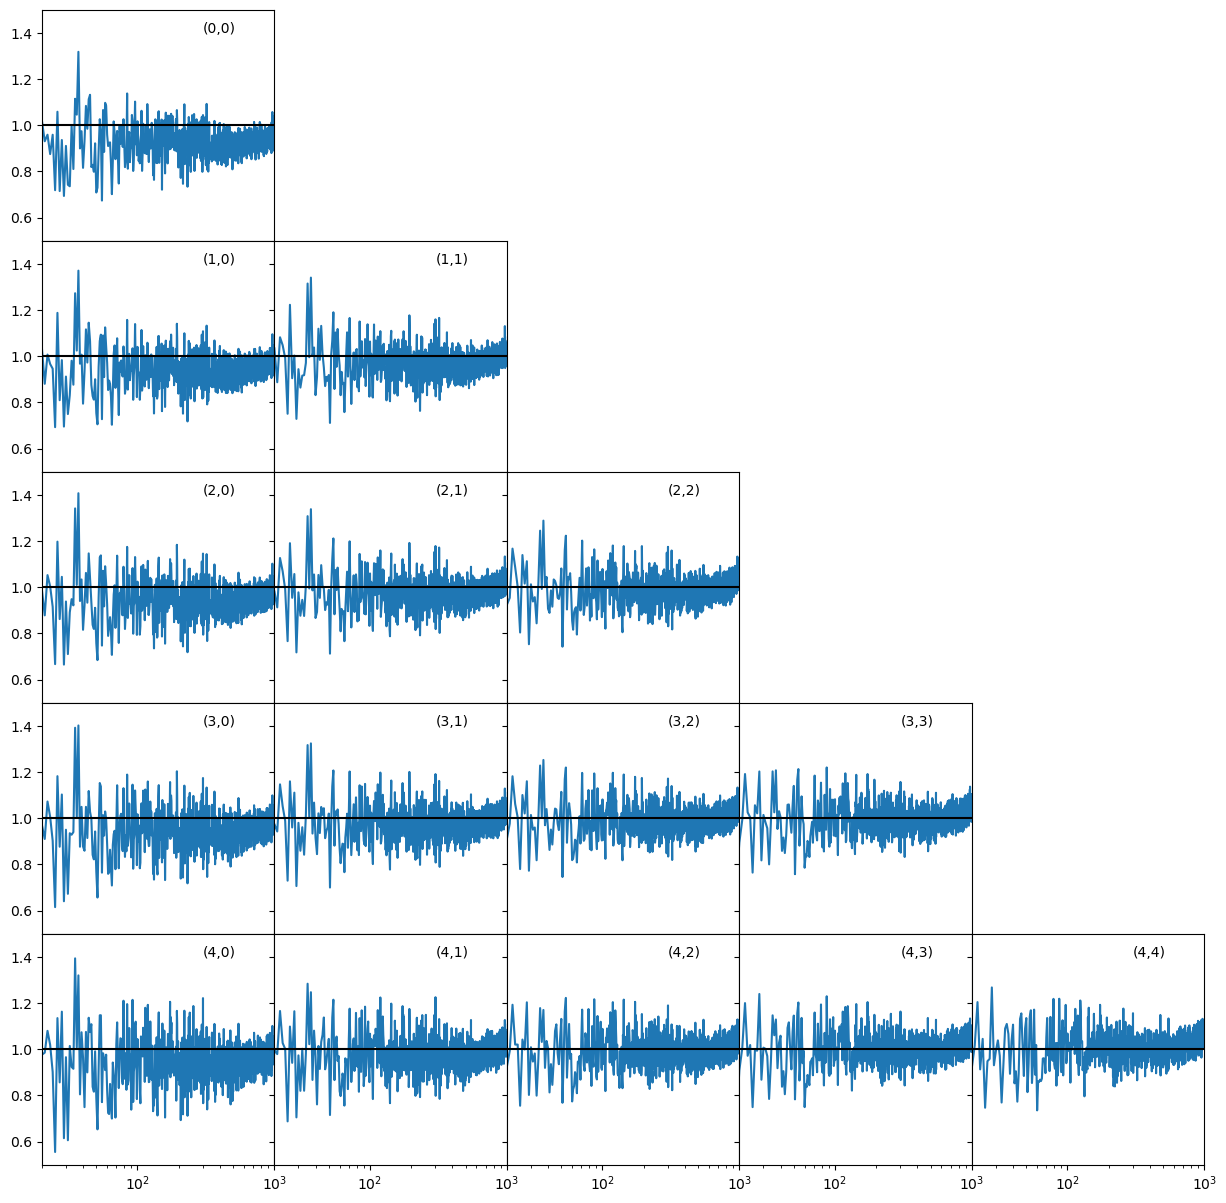

In [380]:
fig,axarr=pl.subplots(5,5,figsize=[15,15],sharex=True,sharey=True)
kk=0
for ii in range(5):
    for jj in range(5):
        if ii<jj:
            axarr[ii,jj].axis("off")
        else:
            pl.sca(axarr[ii,jj])
            #pl.loglog(clkk[:,kk])
            pl.semilogx(clkk[:,kk]/clth_obs[:,kk])
            pl.plot([20,1000],[1,1],'k-')
            pl.text(300,1.4,f"({ii},{jj})")
            kk+=1
pl.ylim([0.5,1.5])
pl.xlim([20,1000])

pl.subplots_adjust(hspace=0,wspace=0)

In [64]:
# also try clgk 
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
clgk=np.zeros((1001,15))

kk=0
for ii in range(5):
    
    lensing_masked = []
    for ll in range(len(lensing[ii])):
        lensing_masked.append(lensing[ii][ll]*mask)
    
    for jj in range(5):
        if ii>=jj:
            delta = (galmap[jj]/(sum(galmap[jj])/sum(mask))-1)*mask
            tmp = hp.anafast([delta,np.zeros(len(mask)),np.zeros(len(mask))], 
                               lensing_masked, 
                               lmax=1000)/fsky
            clgk[:,kk]=tmp[3]
            kk+=1   
# save:
fname=root+"clgk-pseudo-cl-w-fsky-nside-512.txt"
np.savetxt(fname, clgk)

In [21]:
# ccl theory:
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
ell=np.arange(1,3*nside)
clgkth=np.zeros((3*nside,15))

kk=0
for ii in range(5):
    nz =  NZ_SOURCE_uniform[ii]
    nzsamp = np.interp(zsamp, nz[:,0], nz[:,1])
    she1 = ccl.WeakLensingTracer(cosmo_ccl, dndz=(zsamp, nzsamp))
    
    for jj in range(5):
        if ii>=jj:
            counts = COUNTS[jj]
            nz = counts/np.sum(counts)/dz
            clu1 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(z_bin[::-1], nz[::-1]), 
                                              bias=(z_bin[::-1],np.ones(len(nz))))
            
            tmp=ccl.angular_cl(cosmo_ccl, she1, clu1, ell)
            clgkth[:,kk] = np.append(0, tmp)
            kk+=1

# save
fname=root+"clgk-theory-z_bin-nside-512.txt"
np.savetxt(fname, clgkth)
print("save: ",fname)

save:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/clgk-theory-z_bin-nside-512.txt


In [60]:
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
fname = root+"clgk-theory-z_bin-nside-512.txt"
clth = np.loadtxt(fname)

clth_obs = clth*pixwin[:,None]#**0.8#+0.07e-10

/tmp/ipykernel_1657124/4261492971.py:11: RuntimeWarning: invalid value encountered in divide
  pl.semilogx(clgk[:,kk]/clth_obs[:,kk])


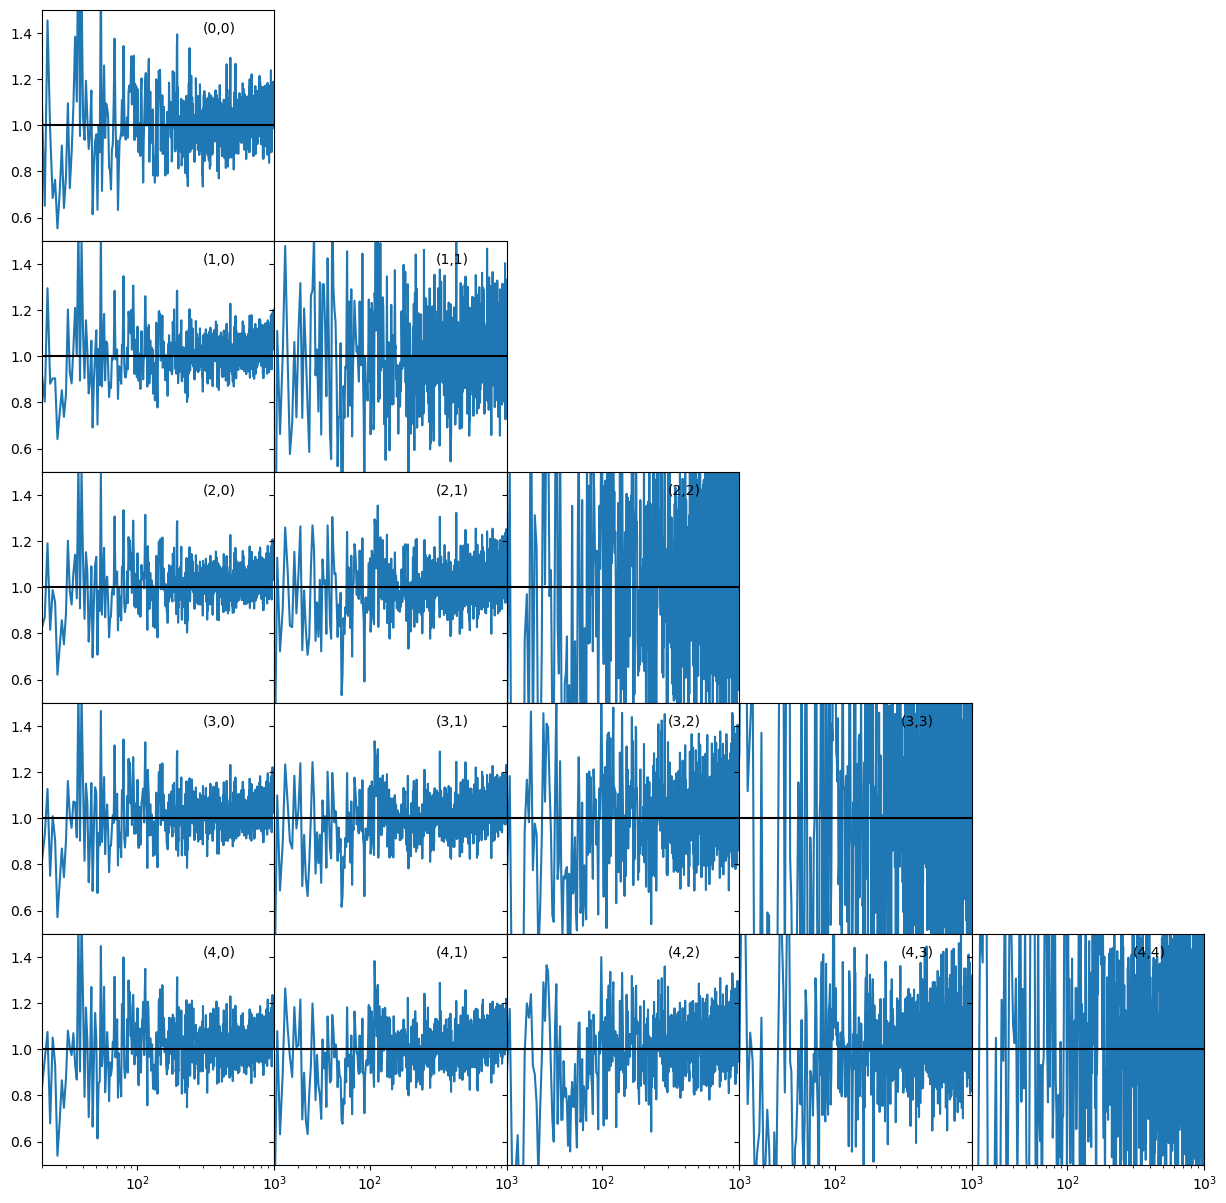

In [67]:
fig,axarr=pl.subplots(5,5,figsize=[15,15],sharex=True,sharey=True)
kk=0
for ii in range(5):
    for jj in range(5):
        if ii<jj:
            axarr[ii,jj].axis("off")
        else:
            pl.sca(axarr[ii,jj])
            #pl.loglog(clgk[:,kk])
            #pl.loglog(clth_obs[:,kk])
            pl.semilogx(clgk[:,kk]/clth_obs[:,kk])
            pl.plot([20,1000],[1,1],'k-')
            pl.text(300,1.4,f"({ii},{jj})")
            kk+=1
pl.ylim([0.5,1.5])
pl.xlim([20,1000])

pl.subplots_adjust(hspace=0,wspace=0)

Conclusion: CCL theory seems to be fine - gives about 1-2% deviation from measurements;
high ell seems to be over-compensated, corrected by pixwin^0.7;

To do:
- NaMaster measurements with band power
- Generate vd case
- Generate noisy shapes - adding noise map
- Run NaMaster again
- Get covariance matrix (Gaussian NaMaster)

Have all files saved to a directory

# Do VD case without shape noise:
We will adopt the same depth binning and just treat each case as having different masks; do it 10 times for each depth bin:

In [12]:
# load depth map and depth bins:
savedir = "/pscratch/sd/q/qhang/roman-rubin-sims/baselinev3.3/y3/"
sys_info = savedir + "ExgalM5-i-qtl-mean-weights.txt"
fin=np.loadtxt(sys_info)
qtl=fin[:,0]
nquantiles=len(qtl)-1
qweights=fin[:-1,2]
print(qtl)

# load depth map:
root="/pscratch/sd/q/qhang/rubin_baseline_v3.3/MAF-3year/"
fname=root+"baseline_v3_3_10yrs_ExgalM5_i_and_nightlt1095_HEAL.fits"
depth_map = hp.ud_grade(hp.read_map(fname),512)*mask

# pixels:
depth_bin_pixels={}
for ii in range(nquantiles):
    depth_bin_pixels[ii]=np.where((depth_map>=qtl[ii])&(depth_map<qtl[ii+1]))[0]

[24.45635701 25.58412269 25.68054968 25.74725094 25.80403718 25.85731518
 25.90701103 25.9576563  26.02081685 26.11157773 27.36975508]


In [13]:
# load evaluation results:
import yaml
Ntot_lens=[35918.4,55427.4,51599.5,52242.3,27576.9]
#ngal_tot_lens=1.67
ngal_tot_lens=24.4
print(ngal_tot_lens)
lens_y3_armin2 = []
for ii in range(5):
    lens_y3_armin2.append(ngal_tot_lens/sum(Ntot_lens)*Ntot_lens[ii])

print(lens_y3_armin2)
root = '/pscratch/sd/q/qhang/roman-rubin-sims/baselinev3.3/y3/'
fname=root+'fzb/test-pz-with-i-band-coadd-Y3-snr-10.0-lens.yml'
with open(fname, "r") as stream:
    packed_stats=yaml.load(stream,Loader=yaml.Loader)

Ngal_lens_vd={}
for ii in range(5):
    
    N_galaxies=np.zeros(nquantiles)
    for q in range(nquantiles):
        nz = packed_stats["tomo-%d"%(ii+1)]["nz"][q]
        N_galaxies[q]=np.sum(nz[:,1])
    Nmean = sum(N_galaxies*qweights)
    # show
    Ngal_lens_vd[ii]=N_galaxies/Nmean*lens_y3_armin2[ii]
print(Ngal_lens_vd)

24.4
[3.9342397913491607, 6.071113485317455, 5.651833213999538, 5.722240841785833, 3.0205726675480165]
{0: array([3.35739976, 3.65149537, 3.77428165, 3.85774565, 3.93507582,
       3.99619513, 4.05698584, 4.13552086, 4.24823013, 4.32939394]), 1: array([5.55604636, 5.9015125 , 6.01542651, 6.0873895 , 6.12901193,
       6.1573809 , 6.17512519, 6.19834613, 6.23306799, 6.25782238]), 2: array([5.05789102, 5.43939338, 5.56787522, 5.64071446, 5.6958094 ,
       5.7581335 , 5.78431182, 5.82560564, 5.86613273, 5.88245311]), 3: array([4.56149257, 5.23840515, 5.50927971, 5.68179383, 5.79001222,
       5.89713528, 5.97512262, 6.06811595, 6.18542555, 6.31555049]), 4: array([1.82218893, 2.37401557, 2.62298379, 2.84916919, 3.02891264,
       3.15312292, 3.29321547, 3.4525858 , 3.71108339, 3.89827508])}


In [54]:
# load nofz and interpolation

USESHELL={}
USEINDEX={}
NZ_LENS={}
COUNTS={}
MEANZ={}

root="/pscratch/sd/q/qhang/glass_mock/catalog_info/lsst-y3-fzb/"

for lens_bin in range(5):
    
    USESHELL[lens_bin]={}
    USEINDEX[lens_bin]={}
    NZ_LENS[lens_bin]={}
    COUNTS[lens_bin]={}
    MEANZ[lens_bin]={}
    
    for depth_bin in range(10):

        fin = np.loadtxt(root+f"NofZ-lens-tomo-{lens_bin}-VD-{depth_bin}-fzb.dat")
        finzbin = fin[:,0]
        finzz = (finzbin[1:]+ finzbin[:-1])/2.
        finnz = fin[:-1,1]
        N=Ngal_lens_vd[lens_bin][depth_bin]*total_area

        # normalise to nz
        counts = finnz/np.sum(finnz)/(finzbin[1:]-finzbin[:-1]) # notice here dz is constant
        # interpolate the values at z_bin:
        counts = np.interp(z_values_bin_max[::-1], finzz, counts, left=0,right=0)
        # normalise by dz
        counts=counts*(z_values_bin_max[::-1] - z_values_bin_min[::-1])
        counts = counts/np.sum(counts)*N # normalise
        counts = counts[::-1] # this is the number of objects per bin in the same order as the index

        # compute mean redshift too:
        meanz=np.sum(z_bin*counts)/np.sum(counts)
        #print("N", N, "meanz", meanz)

        # n(z) for lens
        nz_lens=counts/np.sum(counts)/(z_bin_edges[:-1]-z_bin_edges[1:])
        # define which shells are used
        useshell = np.where(counts>0)[0] #(0-99 based)
        useindex = z_values_index[useshell].astype(int)
        #print("The following shells (0-99) are used for lens: ",useshell)

        USESHELL[lens_bin][depth_bin]=useshell
        USEINDEX[lens_bin][depth_bin]=useindex
        NZ_LENS[lens_bin][depth_bin]=nz_lens
        COUNTS[lens_bin][depth_bin]=counts
        MEANZ[lens_bin][depth_bin]=meanz

meanz 1.0556616370594345 Ngal 113559820.24064566
meanz 1.0643431942925634 Ngal 147949960.5611777
meanz 1.0696291559167146 Ngal 163465797.9864594
meanz 1.0735339214625192 Ngal 177561796.35126668
meanz 1.0757738576897673 Ngal 188763507.40049133
meanz 1.0795983109584784 Ngal 196504360.73980913
meanz 1.0826681572826629 Ngal 205235005.73186177
meanz 1.0869203572810164 Ngal 215167053.00585428
meanz 1.0950377743817576 Ngal 231276765.42277673
meanz 1.10087058710498 Ngal 242942654.62638715
mean N 188242672.20667294


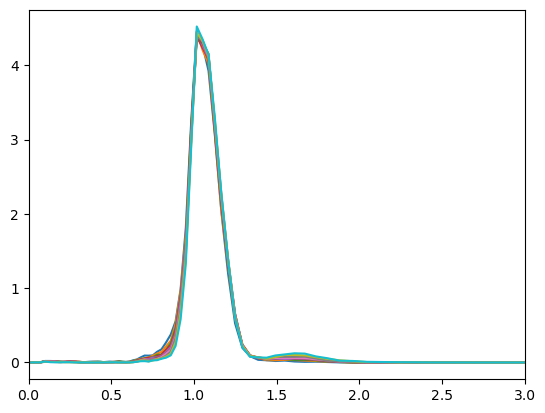

In [103]:
# check:
lens_bin = 4
for ii in range(10):
    pl.plot(z_bin, NZ_LENS[lens_bin][ii])
pl.xlim([0,3])

meanN = 0
for ii in range(10):
    print("meanz", MEANZ[lens_bin][ii], "Ngal", sum(COUNTS[lens_bin][ii]))
    meanN += sum(COUNTS[lens_bin][ii])/10
print("mean N", meanN)

In [104]:
# load these maps here and convert to e1, e2:
min_shells = []
for tomo_lens in range(5):
    for depth_bin in range(10):
        min_shells.append(USESHELL[tomo_lens][depth_bin].min())
min_shells=np.array(min_shells)
print(min_shells.min())

16


In [45]:
# density map without noise:
savedir="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"

# this is the delta map with nz effects
delta_mod={}# this is the modification map we first construct these maps for each bin

for ii in range(5):
    frac = Ngal_lens_vd[ii]/lens_y3_armin2[ii]
    delta_mod[ii]=np.zeros(len(mask))
    for depth_bin in range(10):
        pixels = depth_bin_pixels[depth_bin]
        delta_mod[ii][pixels]=(frac[depth_bin]-1)

In [51]:
simroot

'/global/cfs/cdirs/des/mgatti/Dirac_mocks/runsK/run017/'

In [56]:
delta_map={}
for ii in range(5):
    delta_map[ii]=np.zeros(len(mask))

for shelli in range(16,100):
    
    if shelli%20==0:
        print(f"Doing shell = {shelli}...")
    
    dens = hp.read_map(simroot + f"lens_{shelli+1}_512.fits")#1-100
    
    for ii in range(5):
        for depth_bin in range(10):
            useshell = USESHELL[ii][depth_bin]
            nz_lens = COUNTS[ii][depth_bin]/sum(COUNTS[ii][depth_bin]) # notice here we don't want the dz factor!
            pixels = depth_bin_pixels[depth_bin]
        
            if shelli in useshell:
                delta_map[ii][pixels] += dens[pixels]*nz_lens[shelli]

Doing shell = 20...
Doing shell = 40...
Doing shell = 60...
Doing shell = 80...


In [57]:
# save map
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
for ii in range(5):
    fname=savedir+f"deltamap-vd-nzonly-lens-tomo-{ii}-nside-512.fits"
    hp.write_map(fname, delta_map[ii], overwrite=True)
    print("Written: ", fname)
    
    fname=savedir+f"deltamap-vd-lens-tomo-{ii}-nside-512.fits"
    hp.write_map(fname, delta_map[ii]+delta_mod[ii], overwrite=True)
    print("Written: ", fname)

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-vd-nzonly-lens-tomo-0-nside-512.fits
Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-vd-lens-tomo-0-nside-512.fits


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-vd-nzonly-lens-tomo-1-nside-512.fits
Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-vd-lens-tomo-1-nside-512.fits


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-vd-nzonly-lens-tomo-2-nside-512.fits
Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-vd-lens-tomo-2-nside-512.fits


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-vd-nzonly-lens-tomo-3-nside-512.fits
Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-vd-lens-tomo-3-nside-512.fits


setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-vd-nzonly-lens-tomo-4-nside-512.fits
Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/deltamap-vd-lens-tomo-4-nside-512.fits


In [105]:
# galaxy map:

# now compute galaxy number per pixel:
# generate lens galaxy map:
bias=1
Npix = np.sum(mask)
np.random.seed(1234)
# this is just to make the galaxy maps reproducible
savedir="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"

for lens_bin in range(5):

    counts = COUNTS[lens_bin]
    useshell = USESHELL[lens_bin]
    useindex = USEINDEX[lens_bin]
    galmap = np.zeros(len(mask))
    
    for depth_bin in range(10):
        
        for ii,index in enumerate(useindex[depth_bin]):
            dens = hp.read_map(simroot + f"lens_{index}_512.fits")
            pixels = depth_bin_pixels[depth_bin]
            
            Ngal_perpix = counts[depth_bin]
            Ngal_perpix = Ngal_perpix[useshell[depth_bin]]/Npix
            
            exp_Ngal = Ngal_perpix[ii]*(1+bias*dens[pixels])
            #exp_Ngal = exp_Ngal[mask.astype(bool)]
            # set anything smaller than 0 to 0
            #exp_Ngal[exp_Ngal<0]=0
            galmap[pixels] += np.random.poisson(lam=exp_Ngal)

    # save galmap
    fname=savedir+f"galmap-vd-lens-tomo-{lens_bin}-nside-512.fits"
    hp.write_map(fname, galmap, overwrite=True)
    print("Written: ", fname)

setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/galmap-vd-lens-tomo-0-nside-512.fits


setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/galmap-vd-lens-tomo-1-nside-512.fits


setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/galmap-vd-lens-tomo-2-nside-512.fits


setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/galmap-vd-lens-tomo-3-nside-512.fits


setting the output map dtype to [dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/galmap-vd-lens-tomo-4-nside-512.fits


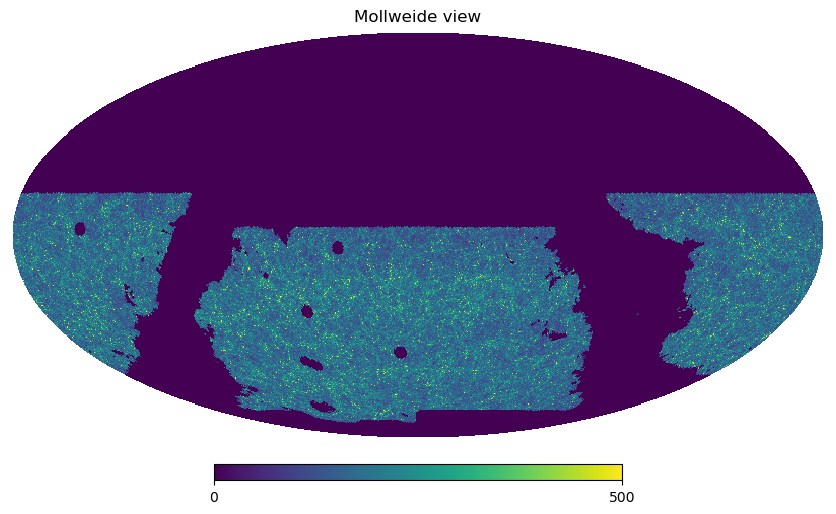

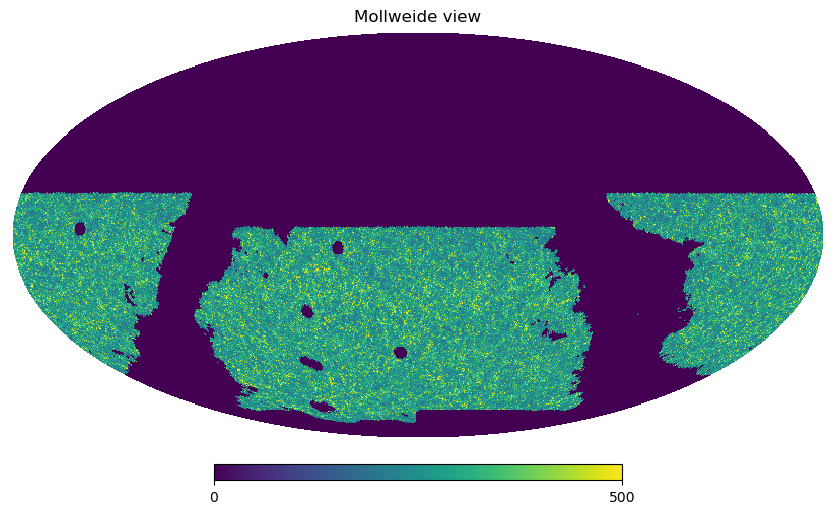

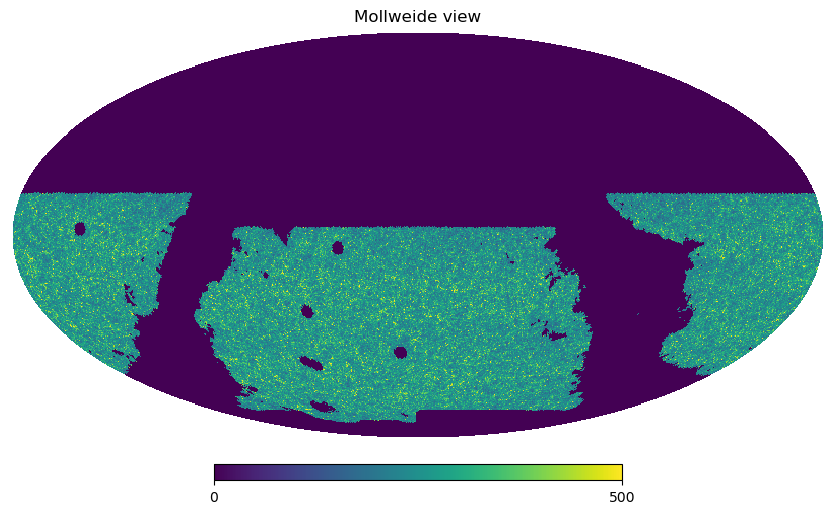

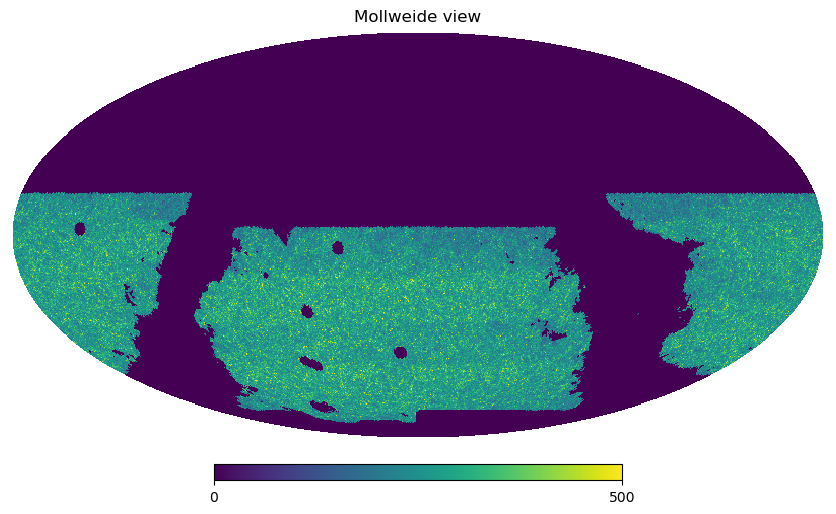

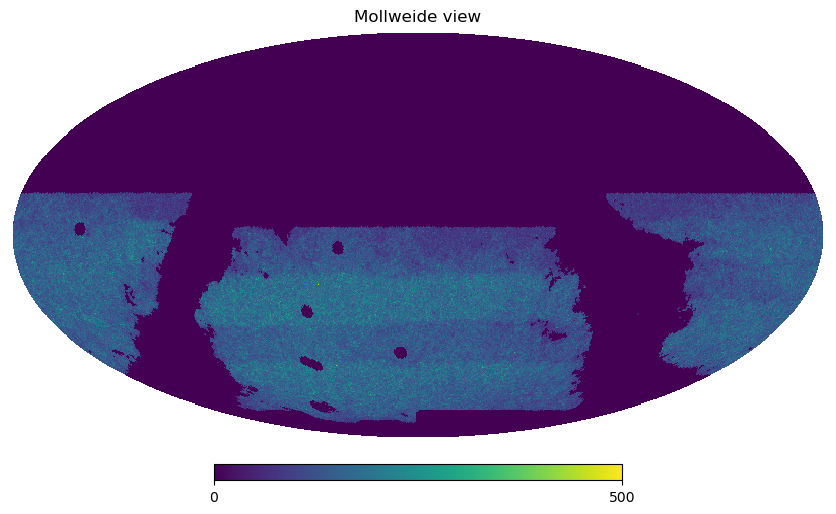

In [107]:
galmap={}

savedir="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
for ii in range(5):
    fname=savedir+f"galmap-vd-lens-tomo-{ii}-nside-512.fits"
    #fname=savedir+f"deltamap-vd-lens-tomo-{ii}-nside-512.fits"
    #fname=savedir+f"deltamap-vd-nzonly-lens-tomo-{ii}-nside-512.fits"
    galmap[ii]=hp.read_map(fname)
    hp.mollview(galmap[ii],max=500)

In [15]:
root="/pscratch/sd/q/qhang/glass_mock/catalog_info/lsst-y3-fzb/"
ell=np.arange(1,3*nside)

for depth_bin in [0,9]:
    clth = np.zeros((3*nside,5))
    for lens_bin in range(5):
        # try ccl:
        counts = COUNTS[lens_bin][depth_bin]
        nz = counts/np.sum(counts)/dz
        clu1 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(z_bin[::-1], nz[::-1]), 
                                              bias=(z_bin[::-1],np.ones(len(finzz))))

        tmp=ccl.angular_cl(cosmo_ccl, clu1, clu1, ell)
        clth[:,lens_bin] = np.append(0, tmp)

    root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
    fname = root+f"clgg-theory-depth-qtl-{depth_bin}-z_bin-nside-512.txt"
    np.savetxt(fname, clth)

source: only difference here is the n(z); additional effect is noise

In [26]:
# noiseless case:
root="/pscratch/sd/q/qhang/glass_mock/catalog_info/lsst-y3-fzb/"
NZ_SOURCE={}
SOURCE_SHELL={}

for tomo_source in range(5):
    NZ_SOURCE[tomo_source]={}
    SOURCE_SHELL[tomo_source]={}
    for depth_bin in range(10):
        # normalise to nz
        fin = np.loadtxt(root+f"NofZ-source-tomo-{tomo_source}-VD-{depth_bin}-fzb.dat")
        finzbin = fin[:,0]
        finzz = (finzbin[1:]+ finzbin[:-1])/2.
        finnz = fin[:-1,1]

        nz_source = finnz/np.sum(finnz)/(finzbin[1:]-finzbin[:-1]) # notice here dz is constant
        # interpolate the values at z_bin:
        nz_source = np.interp(z_values_bin_max[::-1], finzz, nz_source,left=0,right=0)
        nz_source=nz_source*(z_values_bin_max[::-1] - z_values_bin_min[::-1])
        nz_source = nz_source/np.sum(nz_source) # normalise
        nz_source=nz_source[::-1] # (0-99 base, same ordering as index)

        source_shell = np.where(nz_source>0)[0]
        #print("The following shells (0-99) are used for source: ",source_shell)

        NZ_SOURCE[tomo_source][depth_bin]=nz_source
        SOURCE_SHELL[tomo_source][depth_bin]=source_shell

(0.0, 3.0)

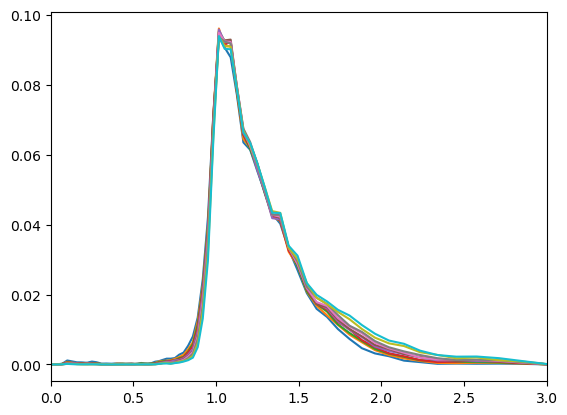

In [27]:
# check:
tomo_source = 4
for ii in range(10):
    pl.plot(z_bin, NZ_SOURCE[tomo_source][ii])
pl.xlim([0,3])

In [39]:
# load these maps here and convert to e1, e2:
min_shells = []
for tomo_source in range(5):
    for depth_bin in range(10):
        min_shells.append(SOURCE_SHELL[tomo_source][depth_bin].min())
min_shells=np.array(min_shells)
print(min_shells.min())

16


In [41]:
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"

kappa_source={}
e1_source={}
e2_source={}

for ii in range(5):
    kappa_source[ii]=np.zeros(len(mask))
    e1_source[ii]=np.zeros(len(mask))
    e2_source[ii]=np.zeros(len(mask))
    

for shelli in range(16,100):
    
    if shelli%20==0:
        print(f"Doing shell = {shelli}...")
    
    kappa = hp.read_map(simroot + f"kappa_{shelli}_512.fits")
    # convert to e1, e2:
    e1, e2 = gk_inv(kappa, np.zeros(len(kappa)), nside, 3*nside-1)

    for ii in range(5):
        
        for depth_bin in range(10):
            
            source_shell = SOURCE_SHELL[ii][depth_bin]
            nz_source = NZ_SOURCE[ii][depth_bin]
            pixels = depth_bin_pixels[depth_bin]
        
            if shelli in source_shell:
                # weight with nz_source
                kappa_source[ii][pixels] += kappa[pixels]*nz_source[shelli]
                e1_source[ii][pixels] += e1[pixels]*nz_source[shelli]
                e2_source[ii][pixels] += e2[pixels]*nz_source[shelli]

/tmp/ipykernel_1987589/912852787.py:16: RuntimeWarning: divide by zero encountered in divide
  kalmsE = alms / (1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5)
/tmp/ipykernel_1987589/912852787.py:16: RuntimeWarning: invalid value encountered in divide
  kalmsE = alms / (1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5)
/tmp/ipykernel_1987589/912852787.py:20: RuntimeWarning: divide by zero encountered in divide
  kalmsB = alms / (1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5)
/tmp/ipykernel_1987589/912852787.py:20: RuntimeWarning: invalid value encountered in divide
  kalmsB = alms / (1. * ((ell * (ell + 1.)) / ((ell + 2.) * (ell - 1))) ** 0.5)


Doing shell = 20...
Doing shell = 40...
Doing shell = 60...
Doing shell = 80...


In [42]:
# save map
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
for ii in range(5):
    fname=root+f"kappa-true-vd-tomo-{ii}-nside-512.fits"
    hp.write_map(fname, [kappa_source[ii], e1_source[ii], e2_source[ii]], overwrite=True)
    print("Written: ", fname)

setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]
setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/kappa-true-vd-tomo-0-nside-512.fits


setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/kappa-true-vd-tomo-1-nside-512.fits


setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/kappa-true-vd-tomo-2-nside-512.fits


setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/kappa-true-vd-tomo-3-nside-512.fits
Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/kappa-true-vd-tomo-4-nside-512.fits


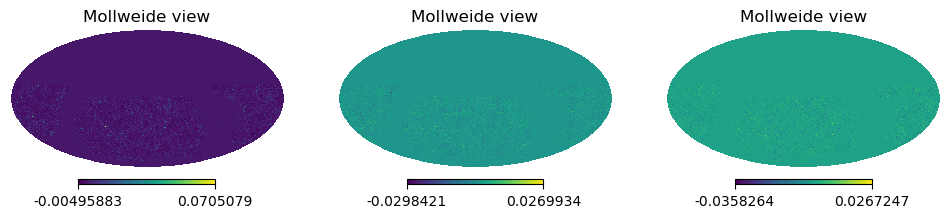

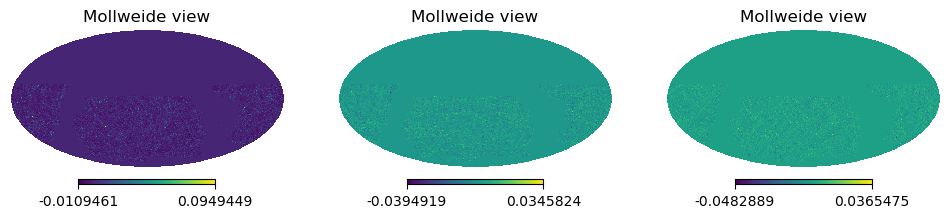

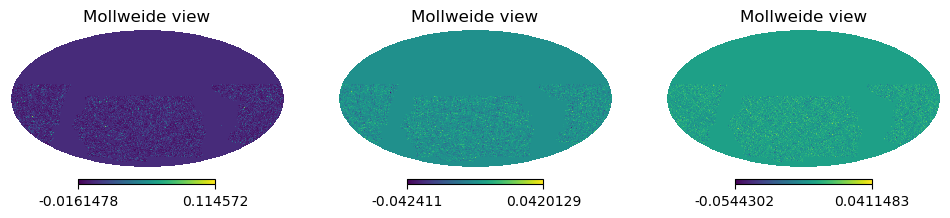

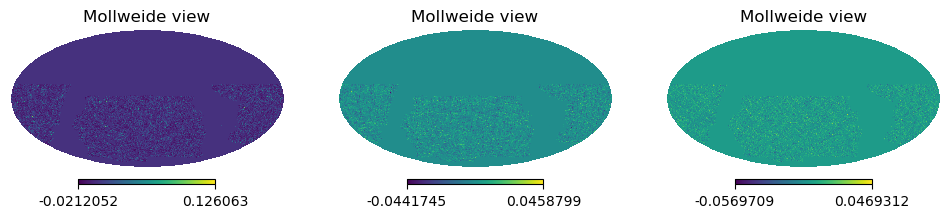

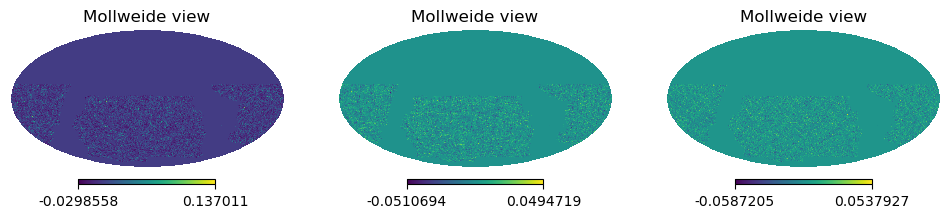

In [45]:
# show lensing maps:
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
for ii in range(5):
    fname=root+f"kappa-true-vd-tomo-{ii}-nside-512.fits"
    maps = hp.read_map(fname, field=[0,1,2])
    fig,axarr=pl.subplots(1,3,figsize=[12,3])
    for hh in range(3):
        pl.sca(axarr[hh])
        hp.mollview(maps[hh],hold=True)

In [63]:
# let's check if the vd case is different from uniform case for lensing:

root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
ii=4
fname=root+f"kappa-true-tomo-{ii}-nside-512.fits"
map1 = hp.read_map(fname,field=[0,1,2])
fname=root+f"kappa-true-vd-tomo-{ii}-nside-512.fits"
map2 = hp.read_map(fname,field=[0,1,2])

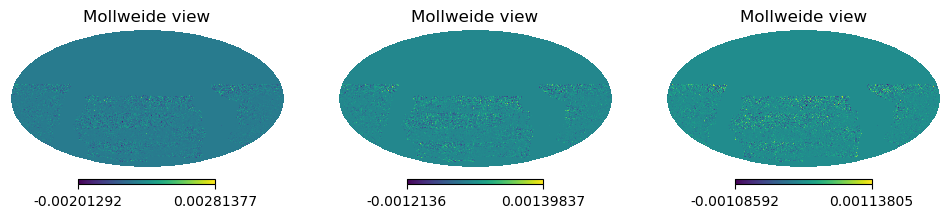

In [67]:
fig,axarr=pl.subplots(1,3,figsize=[12,3])
for ii in range(3):
    pl.sca(axarr[ii])
    hp.mollview(map1[ii]*mask-map2[ii]*mask,hold=True)

In [55]:
root="/pscratch/sd/q/qhang/glass_mock/catalog_info/lsst-y3-fzb/"
NZ_SOURCE_uniform={}
for tomo_source in range(5):
    NZ_SOURCE_uniform[tomo_source]={}
    for depth_bin in [0,5,9]:
        fin = np.loadtxt(root+f"NofZ-source-tomo-{tomo_source}-VD-{depth_bin}-fzb.dat")
        finzbin = fin[:,0]
        #finzz = (finzbin[1:]+ finzbin[:-1])/2.
        finzz = finzbin[1:]
        finnz = fin[:-1,1]

        NZ_SOURCE_uniform[tomo_source][depth_bin]=np.c_[finzz, finnz]

In [17]:
# compute theory
ell=np.arange(1,3*nside)
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"

for depth_bin in [0,9]:
    clth=np.zeros((3*nside, 15))
    zsamp = np.linspace(0,3,300)
    kk=0
    for ii in range(5):
        nz =  NZ_SOURCE_uniform[ii][depth_bin]
        nzsamp = np.interp(zsamp, nz[:,0], nz[:,1])
        she1 = ccl.WeakLensingTracer(cosmo_ccl, dndz=(zsamp, nzsamp))
        for jj in range(5):
            if ii>=jj:

                nz =  NZ_SOURCE_uniform[jj][depth_bin] # no normalization
                nzsamp = np.interp(zsamp, nz[:,0], nz[:,1])
                she2 = ccl.WeakLensingTracer(cosmo_ccl, dndz=(zsamp, nzsamp))

                tmp=ccl.angular_cl(cosmo_ccl, she1, she2, ell)

                clth[:,kk] = np.append(0, tmp)
                kk+=1
    # save:
    fname = root+f"clkk-theory-depth-qtl-{depth_bin}-nside-512.txt"
    np.savetxt(fname, clth)
    print("Written: ", fname)

Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/clkk-theory-depth-qtl-0-nside-512.txt
Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/clkk-theory-depth-qtl-9-nside-512.txt


In [71]:
# compute theory
ell=np.arange(1,3*nside)
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"


clth=np.zeros((3*nside, 15))
zsamp = np.linspace(0,3,300)
kk=0
for ii in range(5):
    nz =  NZ_SOURCE_uniform_UD[ii]
    nzsamp = np.interp(zsamp, nz[:,0], nz[:,1])
    she1 = ccl.WeakLensingTracer(cosmo_ccl, dndz=(zsamp, nzsamp))
    for jj in range(5):
        if ii>=jj:

            nz =  NZ_SOURCE_uniform_UD[jj] # no normalization
            nzsamp = np.interp(zsamp, nz[:,0], nz[:,1])
            she2 = ccl.WeakLensingTracer(cosmo_ccl, dndz=(zsamp, nzsamp))

            tmp=ccl.angular_cl(cosmo_ccl, she1, she2, ell)

            clth[:,kk] = np.append(0, tmp)
            kk+=1
# save:
fname = root+f"clkk-theory-check-nside-512.txt"
np.savetxt(fname, clth)
print("Written: ", fname)

Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/clkk-theory-check-nside-512.txt


In [22]:
# ccl theory:
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
ell=np.arange(1,3*nside)

for depth_bin in [5]:
    clgkth=np.zeros((3*nside,15))

    kk=0
    for ii in range(5):
        nz =  NZ_SOURCE_uniform[ii][depth_bin]
        nzsamp = np.interp(zsamp, nz[:,0], nz[:,1])
        she1 = ccl.WeakLensingTracer(cosmo_ccl, dndz=(zsamp, nzsamp))

        for jj in range(5):
            if ii>=jj:
                counts = COUNTS[jj][depth_bin]
                nz = counts/np.sum(counts)/dz
                clu1 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(z_bin[::-1], nz[::-1]), 
                                                  bias=(z_bin[::-1],np.ones(len(nz))))

                tmp=ccl.angular_cl(cosmo_ccl, she1, clu1, ell)
                clgkth[:,kk] = np.append(0, tmp)
                kk+=1

    # save
    fname=root+f"clgk-theory-depth-qtl-{depth_bin}-z_bin-nside-512.txt"
    np.savetxt(fname, clgkth)
    print("save: ",fname)

save:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/clgk-theory-depth-qtl-5-z_bin-nside-512.txt


In [64]:
# ccl theory:
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
ell=np.arange(1,3*nside)

clgkth=np.zeros((3*nside,15))

kk=0
for ii in range(5):
    nz =  NZ_SOURCE_uniform_UD[ii]
    nzsamp = np.interp(zsamp, nz[:,0], nz[:,1])
    she1 = ccl.WeakLensingTracer(cosmo_ccl, dndz=(zsamp, nzsamp))

    for jj in range(5):
        if ii>=jj:
            counts = COUNTS_UD[jj]
            nz = counts/np.sum(counts)/dz
            clu1 = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(z_bin[::-1], nz[::-1]), 
                                              bias=(z_bin[::-1],np.ones(len(nz))))

            tmp=ccl.angular_cl(cosmo_ccl, she1, clu1, ell)
            clgkth[:,kk] = np.append(0, tmp)
            kk+=1

# save
fname=root+f"clgk-theory-check-z_bin-nside-512.txt"
np.savetxt(fname, clgkth)
print("save: ",fname)

save:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/clgk-theory-check-z_bin-nside-512.txt


# Check binned results:

In [68]:
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
ell=np.loadtxt(root+"effective_ells.txt")
bw=np.load(root+"wb-clgg-binning-20-2000-nell-20-log.npy")

In [69]:
def convolve_bandpower(bw, cl_th):
    # convolve with band power:
    usebw=bw[0,:,0,:]
    L=len(cl_th)
    L2=usebw.shape[1]
    if L2>=L: 
        cl_th_binned=np.dot(cl_th, usebw[:,:L].T)
    else:
        cl_th_binned=np.dot(cl_th[:L2], usebw.T)
    return cl_th_binned

In [112]:
clgg_binned_un = np.loadtxt(root+"data-nmt-clgg-512-binning-20-2000.txt")
clgg_binned_vd = np.loadtxt(root+"data-nmt-clgg-vd-512-binning-20-2000.txt")

# covmat
clgg_cov = {}
for ii in range(5):
    fname = root+f"cov-nmt-clgg-tomo-{ii}-512-binning-20-2000.txt"
    clgg_cov[ii]=np.loadtxt(fname)
    
# theory - binned:
clgg_theory = np.loadtxt(root+"clgg-theory-z_bin-nside-512.txt")
# add pixwin and shotnoise
#pshot=np.array([3.13281099e-07, 2.03870247e-07, 2.18472948e-07, 2.16053153e-07, 4.09547021e-07])
pshot=np.array([3.862394178701377e-08, 2.538344765781688e-08, 2.4507395444259033e-08, 
                 2.1342497199973858e-08, 3.357135958745967e-08])
pixwin=hp.pixwin(nside,lmax=3*nside-1)**2
clgg_theory_binned = []
for ii in range(5):
    tmp=(clgg_theory[:,ii]*pixwin)+pshot[ii]
    # binned version:
    clgg_theory_binned.append(convolve_bandpower(bw, tmp))

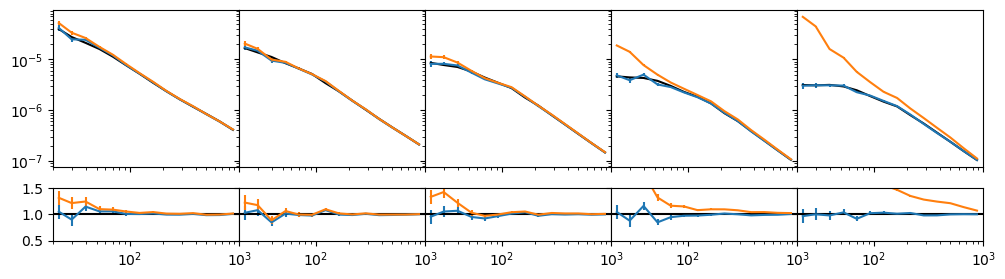

In [113]:
fig,axarr=pl.subplots(2,5,figsize=[12,3],sharey='row',sharex=True,
                     gridspec_kw={'height_ratios': [3, 1]})
for ii in range(5):
    pl.sca(axarr[0,ii])
    yerr=np.sqrt(np.diag(clgg_cov[ii]))
    pl.errorbar(ell, clgg_binned_un[ii,:], yerr=yerr)
    pl.errorbar(ell, clgg_binned_vd[ii,:], yerr=yerr)
    pl.plot(ell, clgg_theory_binned[ii], 'k-')
    pl.xscale("log")
    pl.yscale("log")
    
    pl.sca(axarr[1,ii])
    ratio=clgg_binned_un[ii,:]/clgg_theory_binned[ii]
    err=yerr/clgg_theory_binned[ii]
    pl.errorbar(ell,ratio,yerr=err)
    
    ratio=clgg_binned_vd[ii,:]/clgg_theory_binned[ii]
    pl.errorbar(ell,ratio,yerr=err)
    
    pl.plot([20,1000],[1,1],'k-')
    pl.ylim([0.5,1.5])
pl.xlim([20,1000])
pl.subplots_adjust(wspace=0)

In [114]:
clgk_binned_un = np.loadtxt(root+"data-nmt-clgk-512-binning-20-2000.txt")
clgk_binned_vd = np.loadtxt(root+"data-nmt-clgk-vd-512-binning-20-2000.txt")

# covmat
clgk_cov = {}
kk=0
for ii in range(5):
    for jj in range(5):
        if ii>=jj:
            fname = root+f"cov-nmt-clgk-tomo-{ii}{jj}-512-binning-20-2000.txt"
            clgk_cov[kk]=np.loadtxt(fname)
            kk+=1
            
# theory:
# theory - binned:
clgk_theory = np.loadtxt(root+"clgk-theory-z_bin-nside-512.txt")
# add pixwin and shotnoise
pixwin=hp.pixwin(nside,lmax=3*nside-1)**2
clgk_theory_binned = []
kk=0
for ii in range(5):
    for jj in range(5):
        if ii>=jj:
            tmp=clgk_theory[:,kk]*pixwin
            # binned version:
            clgk_theory_binned.append(convolve_bandpower(bw, tmp))
            kk+=1

In [115]:
clgk_binned_un_noisy = np.loadtxt(root+"data-noisy-nmt-clgk-512-binning-20-2000.txt")
clgk_binned_vd_noisy = np.loadtxt(root+"data-noisy-nmt-clgk-vd-512-binning-20-2000.txt")

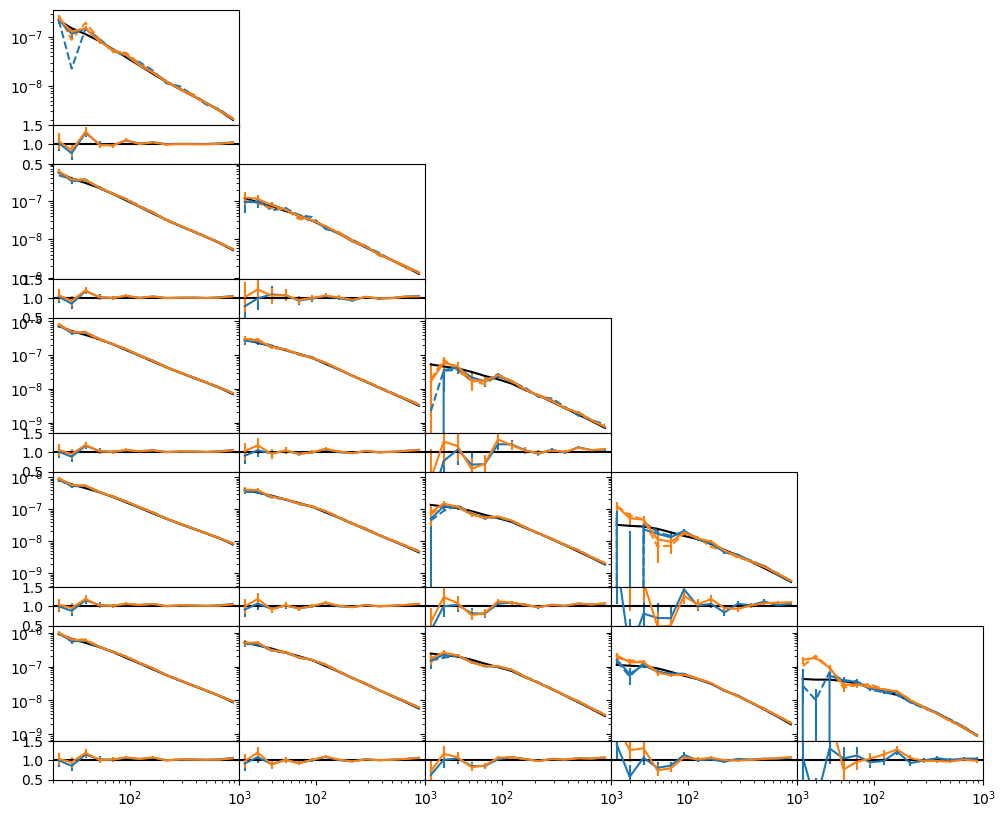

In [116]:
fig,axarr=pl.subplots(10,5,figsize=[12,10],sharex=True, sharey="row",
                      gridspec_kw={'height_ratios': [3, 1, 3, 1, 3, 1, 3, 1, 3, 1]})
kk=0
for ii in range(5):
    for jj in range(5):
        if ii<jj:
            axarr[ii*2,jj].axis("off")
            axarr[ii*2+1,jj].axis("off")
        else:
            pl.sca(axarr[ii*2,jj])
            yerr=np.sqrt(np.diag(clgk_cov[kk]))
            pl.errorbar(ell,clgk_binned_un[kk,:],yerr=yerr)
            pl.errorbar(ell,clgk_binned_vd[kk,:],yerr=yerr)
            pl.plot(ell, clgk_theory_binned[kk],'k-')
            pl.xscale("log")
            pl.yscale("log")
            
            pl.plot(ell, clgk_binned_un_noisy[kk,:],color='C0',ls='--')
            pl.plot(ell, clgk_binned_vd_noisy[kk,:],color='C1',ls='--')
            
            pl.sca(axarr[ii*2+1,jj])
            pl.yscale("linear")
            ratio=clgk_binned_un[kk,:]/clgk_theory_binned[kk]
            err=yerr/clgk_theory_binned[kk]
            pl.errorbar(ell,ratio,yerr=err)
            
            ratio=clgk_binned_vd[kk,:]/clgk_theory_binned[kk]
            pl.errorbar(ell,ratio,yerr=err)
            pl.plot([20,1000],[1,1],'k-')
            pl.ylim([0.5,1.5])
            kk+=1
pl.xlim([20,1000])
pl.subplots_adjust(hspace=0,wspace=0)

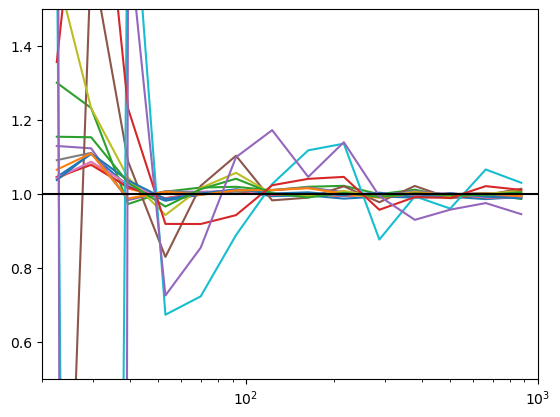

In [117]:
for kk in range(15):
    pl.semilogx(ell, clgk_binned_vd[kk,:]/clgk_binned_un[kk,:])
pl.ylim([0.5,1.5])
pl.xlim([20,1000])
pl.plot([20,1000],[1,1],'k-')

In [22]:
clkk_binned_un = np.loadtxt(root+"data-nmt-clkk-512-binning-20-2000.txt")
clkk_binned_vd = np.loadtxt(root+"data-nmt-clkk-vd-512-binning-20-2000.txt")

# covmat
clkk_cov = {}
kk=0
for ii in range(5):
    for jj in range(5):
        if ii>=jj:
            fname = root+f"cov-nmt-clkk-tomo-{ii}{jj}-512-binning-20-2000.txt"
            clkk_cov[kk]=np.loadtxt(fname)
            kk+=1
            
# theory:
# theory - binned:
clkk_theory = np.loadtxt(root+"clkk-theory-nside-512.txt")
# add pixwin and shotnoise
pixwin=hp.pixwin(nside,lmax=3*nside-1)**2
clkk_theory_binned = []
pshape = np.array([3.7982262757815385e-09, 3.691708135570749e-09, 3.5761122650727328e-09, 
                   3.532698922231069e-09 ,3.406168937618163e-09])
kk=0
for ii in range(5):
    for jj in range(5):
        if ii>=jj:
            tmp=clkk_theory[:,kk]*pixwin
            # binned version:
            clkk_theory_binned.append(convolve_bandpower(bw, tmp))
            kk+=1

In [179]:
clkk_binned_un_noisy = np.loadtxt(root+"data-noisy-nmt-clkk-512-binning-20-2000.txt")
clkk_binned_vd_noisy = np.loadtxt(root+"data-noisy-nmt-clkk-vd-512-binning-20-2000.txt")

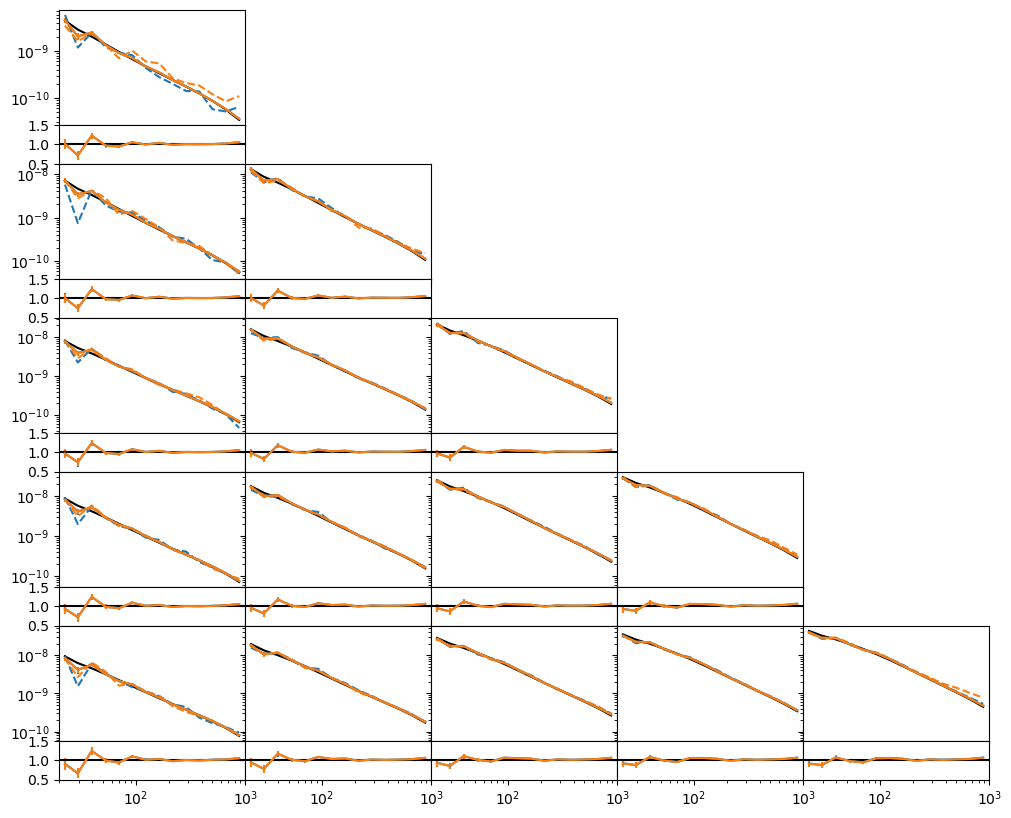

In [35]:
fig,axarr=pl.subplots(10,5,figsize=[12,10],sharex=True, sharey="row",
                      gridspec_kw={'height_ratios': [3, 1, 3, 1, 3, 1, 3, 1, 3, 1]})
kk=0
for ii in range(5):
    for jj in range(5):
        if ii<jj:
            axarr[ii*2,jj].axis("off")
            axarr[ii*2+1,jj].axis("off")
        else:
            pl.sca(axarr[ii*2,jj])
            yerr=np.sqrt(np.diag(clkk_cov[kk]))
            pl.errorbar(ell,clkk_binned_un[kk,:],yerr=yerr)
            pl.errorbar(ell,clkk_binned_vd[kk,:],yerr=yerr)
            pl.plot(ell, clkk_theory_binned[kk],'k-')
            pl.xscale("log")
            pl.yscale("log")
            
            if ii!=jj:
                pl.plot(ell, clkk_binned_un_noisy[kk,:],color='C0',ls='--')
                pl.plot(ell, clkk_binned_vd_noisy[kk,:],color='C1',ls='--')
            elif ii==jj:
                pl.plot(ell, clkk_binned_un_noisy[kk,:]-np.mean(cl_shape_noise[ii]),color='C0',ls='--')
                pl.plot(ell, clkk_binned_vd_noisy[kk,:]-np.mean(cl_shape_noise[ii]),color='C1',ls='--')
                
            pl.sca(axarr[ii*2+1,jj])
            pl.yscale("linear")
            ratio=clkk_binned_un[kk,:]/clkk_theory_binned[kk]
            err=yerr/clkk_theory_binned[kk]
            pl.errorbar(ell,ratio,yerr=err)
            
            ratio=clkk_binned_vd[kk,:]/clkk_theory_binned[kk]
            pl.errorbar(ell,ratio,yerr=err)
            pl.plot([20,1000],[1,1],'k-')
            pl.ylim([0.5,1.5])
            kk+=1
pl.xlim([20,1000])
pl.subplots_adjust(hspace=0,wspace=0)

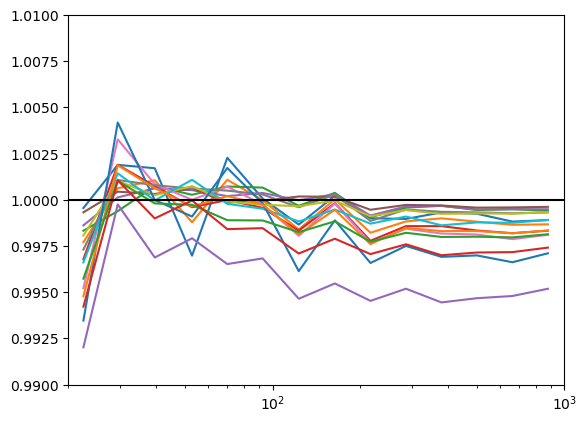

In [49]:
for kk in range(15):
    pl.semilogx(ell, clkk_binned_vd[kk,:]/clkk_binned_un[kk,:])
pl.ylim([0.99,1.01])
pl.xlim([20,1000])
pl.plot([20,1000],[1,1],'k-')

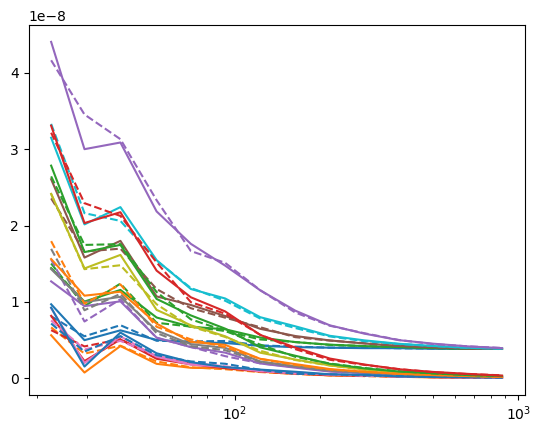

In [180]:
clkk_binned_un_noisy_G = np.loadtxt(root+"data-noisy-nmt-clkk-512-binning-20-2000-shapeN-Gaussian.txt")
for kk in range(15):
    pl.semilogx(ell, clkk_binned_un_noisy[kk,:],color=f'C{kk}')
    pl.semilogx(ell, clkk_binned_un_noisy_G[kk,:],color=f'C{kk}',ls='--')

# Noisy shear maps

In [50]:
import h5py
def read_map_from_hdf5(fname, name, nside):
    """Return the map stored in the hdf5 TXPipe-like file.

    Args:
        fname (str): Path to the hdf5 file
        name (str): Name of the map in th hdf5 file
        nside (int): Map's HEALPix nside.

    Returns:
        array: HEALPix map
    """
    with h5py.File(fname, "r") as f:
        pixel = f[f"maps/{name}/pixel"]
        value = f[f"maps/{name}/value"]

        m = np.zeros(hp.nside2npix(nside))
        m[pixel] = value

        return m

In [61]:
# here we will add noise realisations from salmo:
# degrade from nside=2048 to nside=512 

noiserel = 1
root="/pscratch/sd/q/qhang/glass_mock/catalog_lsst_y3-fzb/uniform/"
fname=root+"source_noise_maps.hdf5"
noise_map = {}

savedir="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
for ii in range(5):
    gamma1=read_map_from_hdf5(fname, f"rotation_{noiserel}/g1_{ii}", 2048)
    gamma1=hp.ud_grade(gamma1,512)
    gamma2=read_map_from_hdf5(fname, f"rotation_{noiserel}/g2_{ii}", 2048)
    gamma2=hp.ud_grade(gamma2,512)
    
    # save these noise files:
    savename=savedir+f"e1-e2-noise-rotation-{noiserel}-tomo-{ii}-nside-512.fits"
    hp.write_map(savename,[np.zeros(len(gamma1)), gamma1, gamma2], overwrite=True)
    print("Written: ", savename)

setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/e1-e2-noise-rotation-1-tomo-0-nside-512.fits


setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/e1-e2-noise-rotation-1-tomo-1-nside-512.fits


setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/e1-e2-noise-rotation-1-tomo-2-nside-512.fits


setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/e1-e2-noise-rotation-1-tomo-3-nside-512.fits


setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/e1-e2-noise-rotation-1-tomo-4-nside-512.fits


In [62]:
# here we will add noise realisations from salmo:
# degrade from nside=2048 to nside=512 
# varying depth noise

noiserel = 1
root="/pscratch/sd/q/qhang/glass_mock/catalog_lsst_y3-fzb/nonuniform/"
fname=root+"source_noise_maps.hdf5"
noise_map = {}

savedir="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
for ii in range(5):
    gamma1=read_map_from_hdf5(fname, f"rotation_{noiserel}/g1_{ii}", 2048)
    gamma1=hp.ud_grade(gamma1,512)
    gamma2=read_map_from_hdf5(fname, f"rotation_{noiserel}/g2_{ii}", 2048)
    gamma2=hp.ud_grade(gamma2,512)
    
    # save these noise files:
    savename=savedir+f"e1-e2-noise-vd-rotation-{noiserel}-tomo-{ii}-nside-512.fits"
    hp.write_map(savename,[np.zeros(len(gamma1)), gamma1, gamma2], overwrite=True)
    print("Written: ", savename)

setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/e1-e2-noise-vd-rotation-1-tomo-0-nside-512.fits


setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/e1-e2-noise-vd-rotation-1-tomo-1-nside-512.fits


setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/e1-e2-noise-vd-rotation-1-tomo-2-nside-512.fits


setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/e1-e2-noise-vd-rotation-1-tomo-3-nside-512.fits


setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


Written:  /pscratch/sd/q/qhang/dirac_mock/desc-project285/e1-e2-noise-vd-rotation-1-tomo-4-nside-512.fits


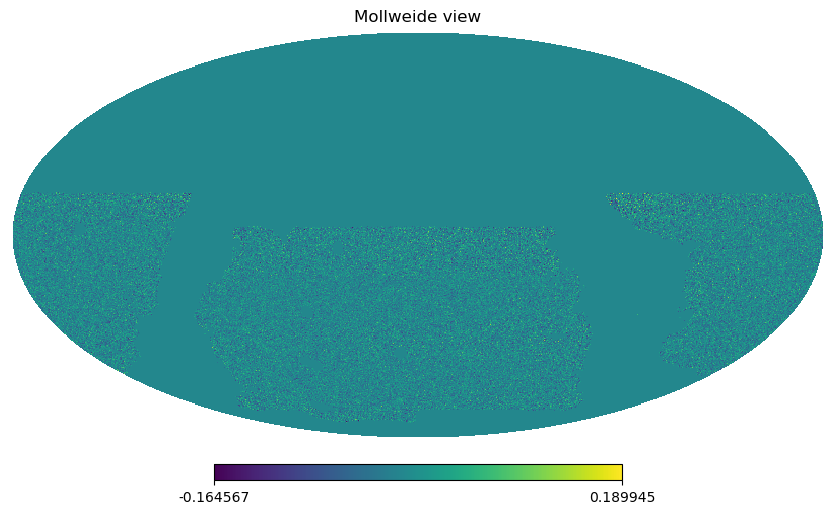

In [63]:
# look at these maps:
hp.mollview(gamma2)

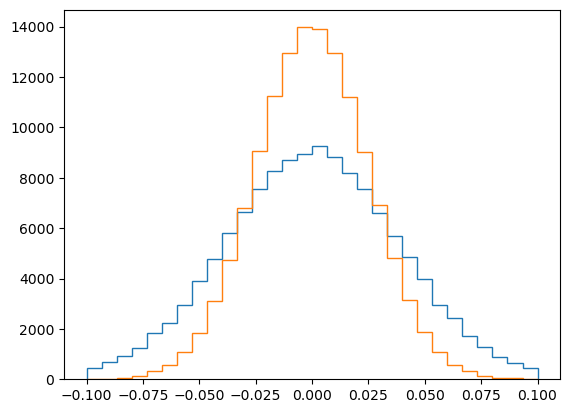

In [64]:
# we can check the scatter of e1, e2 at pixels:
pix0 = depth_bin_pixels[0]
pix9 = depth_bin_pixels[9]
gamma1_set0 = gamma1[pix0]
cc=pl.hist(gamma1_set0,bins=30,range=[-0.1,0.1],histtype='step')
gamma1_set9 = gamma1[pix9]
cc=pl.hist(gamma1_set9,bins=30,range=[-0.1,0.1],histtype='step')

In [29]:
# compute noise spectra of the shape noise map:
noiserel=1
cl_shape_noise=[]
pixwin = hp.pixwin(512,lmax=1000)**2
savedir="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
for ii in range(5):
    # save these noise files:
    savename=savedir+f"e1-e2-noise-rotation-{noiserel}-tomo-{ii}-nside-512.fits"
    maps = hp.read_map(savename, field=[1,2])

    # power spectrum:
    cl_noise = hp.anafast([np.zeros(len(mask)),maps[0],maps[1]],lmax=1000)/fsky

    #pl.plot(cl_noise[1])
    cl_shape_noise.append(cl_noise[1])

In [34]:
for ii in range(5):
    print(np.mean(cl_shape_noise[ii]))

3.7982262757815385e-09
3.691708135570749e-09
3.5761122650727328e-09
3.532698922231069e-09
3.406168937618163e-09


In [ ]:
# inprinciple can estimate this better by using all 10 noise realisations

In [38]:
# load noisy cov mat

# covmat
clkk_cov_noisy = {}
kk=0
for ii in range(5):
    for jj in range(5):
        if ii>=jj:
            fname = root+f"cov-noisy-nmt-clkk-tomo-{ii}{jj}-512-binning-20-2000.txt"
            clkk_cov_noisy[kk]=np.loadtxt(fname)
            kk+=1

(20, 1000)

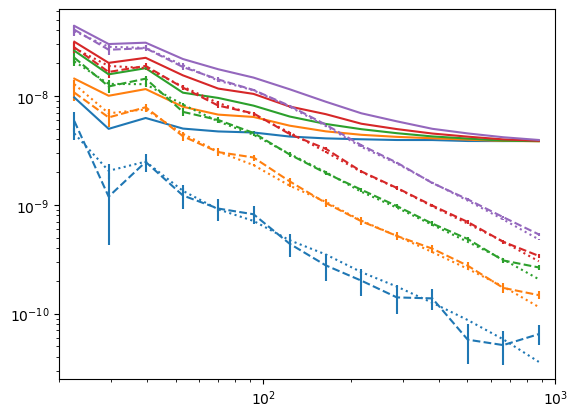

In [41]:
for ii, kk in enumerate([0,2,5,9,14]):
    pl.xscale("log")
    pl.yscale("log")
    yerr=np.sqrt(np.diag(clkk_cov_noisy[kk]))
    pl.errorbar(ell, clkk_binned_un_noisy[kk,:], color=f"C{ii}")
    
    pl.errorbar(ell, clkk_binned_un_noisy[kk,:] -np.mean(cl_shape_noise[ii]),
                yerr=yerr, color=f"C{ii}",ls='--')
    yerr=np.sqrt(np.diag(clkk_cov[kk]))
    pl.errorbar(ell, clkk_binned_un[kk,:],yerr=yerr, color=f"C{ii}",ls=':')
pl.xlim([20,1000])

In [76]:
#cc=pl.hist(maps[0][mask.astype(bool)], bins=30, histtype='step')
# measure std
print(np.std(maps[0][mask.astype(bool)]))
print(np.std(maps[1][mask.astype(bool)]))
# Gaussian with std=0.35 and divide by mean Ngal per pix:
area_pix = hp.nside2pixarea(512, degrees=True)*60**2
Nsource = 3.34*area_pix # arcmin^-1
print(Nsource)
print(0.35/np.sqrt(Nsource))

0.030355758065995834
0.030341723409467322
157.68229359404796
0.027872542101875543


# Noiseless density:

In [65]:
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
clgg_binned_un = np.loadtxt(root+"data-noiseless-nmt-clgg-512-binning-20-2000.txt")
clgg_binned_vd = np.loadtxt(root+"data-noiseless-nmt-clgg-vd-512-binning-20-2000.txt")
clgg_binned_vd2 = np.loadtxt(root+"data-noiseless-nmt-clgg-vd-nzonly-512-binning-20-2000.txt")

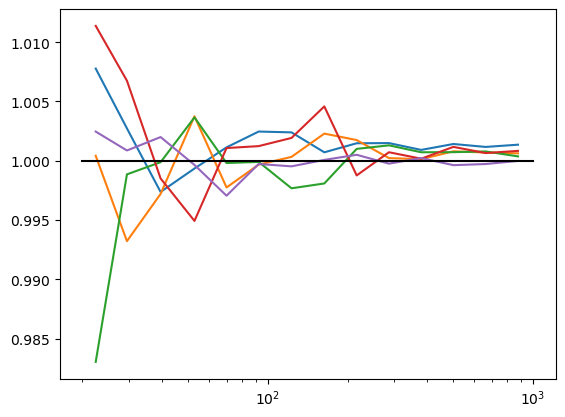

In [104]:
for kk in range(5):
    #pl.plot(clgg_binned_vd[:,kk]/clgg_binned_un[:,kk],color=f'C{kk}')
    pl.semilogx(ell,clgg_binned_vd2[kk,:]/clgg_binned_un[kk,:],color=f'C{kk}')
pl.plot([20,1000],[1,1],'k-')

In [66]:
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
clgk_binned_un = np.loadtxt(root+"data-noiseless-nmt-clgk-512-binning-20-2000.txt")
clgk_binned_vd = np.loadtxt(root+"data-noiseless-nmt-clgk-vd-512-binning-20-2000.txt")
clgk_binned_vd2 = np.loadtxt(root+"data-noiseless-nmt-clgk-vd-nzonly-512-binning-20-2000.txt")

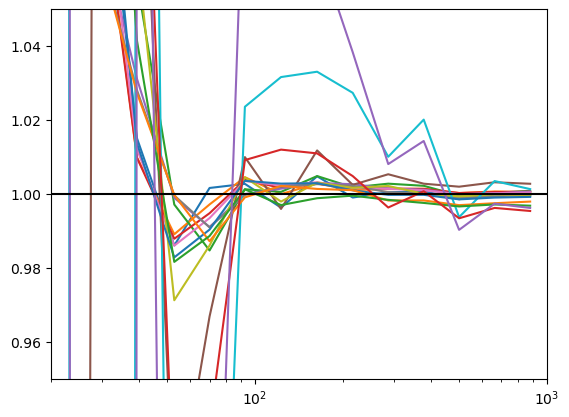

In [106]:
for kk in range(15):
    pl.semilogx(ell, clgk_binned_vd[kk,:]/clgk_binned_un[kk,:])
pl.ylim([0.95,1.05])
pl.xlim([20,1000])
pl.plot([20,1000],[1,1],'k-')

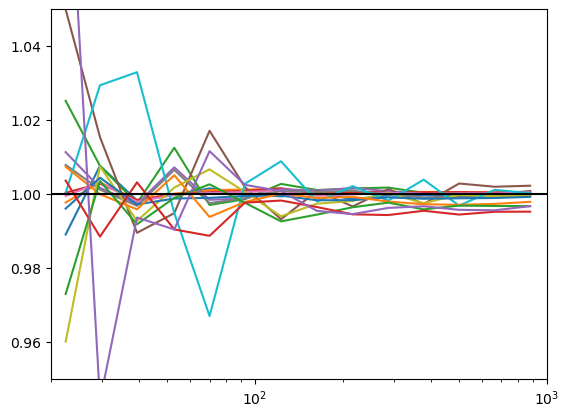

In [107]:
for kk in range(15):
    pl.semilogx(ell, clgk_binned_vd2[kk,:]/clgk_binned_un[kk,:])
pl.ylim([0.95,1.05])
pl.xlim([20,1000])
pl.plot([20,1000],[1,1],'k-')

# Measure chi square in each case, for both noisy and noiseless:

In [188]:
# noisey clgg:
ellmax=[265.9807349941148, 403.1155966170281, 539.8220627877016, 653.0018484000559, 756.7049307487994]
pshot=np.array([3.862394178701377e-08, 2.538344765781688e-08, 2.4507395444259033e-08, 
                 2.1342497199973858e-08, 3.357135958745967e-08])
pixwin=hp.pixwin(nside,lmax=3*nside-1)**2

#pshot[0]*=1.05
#pshot[1]*=1.01
#pshot[2]*=1.04
#pshot[3]*=1.02
#pshot[4]*=1.02

clgg_binned_un = np.loadtxt(root+"data-nmt-clgg-512-binning-20-2000.txt")
clgg_binned_vd = np.loadtxt(root+"data-nmt-clgg-vd-512-binning-20-2000.txt")
clgg_theory = np.loadtxt(root+"clgg-theory-z_bin-nside-512.txt")

# covmat
chi_sq_1=np.zeros(5)
chi_sq_2=np.zeros(5)
for ii in range(5):
    ind_scale = (ell<ellmax[ii])#&(ell>50)
    print("dof: ", sum(ind_scale))
    
    data1 = clgg_binned_un[ii, ind_scale]
    data2 = clgg_binned_vd[ii, ind_scale]
    
    fname = root+f"cov-nmt-clgg-tomo-{ii}-512-binning-20-2000.txt"
    covmat=np.loadtxt(fname)#/fsky
    covmat=covmat[ind_scale,:]
    covmat=covmat[:,ind_scale]
    invcov = np.linalg.inv(covmat)
    
    tmp=(clgg_theory[:,ii]*pixwin)+pshot[ii]
    theory = convolve_bandpower(bw, tmp)
    theory = theory[ind_scale]#*factor[ii]
    
    vec=data1-theory
    chi_sq_1[ii]=np.dot(vec,np.dot(vec,invcov))
    
    vec=data2-theory
    chi_sq_2[ii]=np.dot(vec,np.dot(vec,invcov))
print("chi sq uniform: ", chi_sq_1/sum(ind_scale))
print("chi sq vd: ", chi_sq_2/sum(ind_scale))

dof:  9
dof:  11
dof:  12
dof:  12
dof:  13
chi sq uniform:  [0.67172197 1.51221272 1.12306776 1.75102764 1.44587003]
chi sq vd:  [3.33587821e+00 2.23608214e+00 5.11770279e+00 1.10823937e+02
 4.33240790e+03]


In [ ]:
### clgg_binned_un = np.loadtxt(root+"data-nmt-clgg-512-binning-20-2000.txt")
clgg_theory = np.loadtxt(root+"clgg-theory-z_bin-nside-512.txt")

ind=1

tmp=(clgg_theory[:,ind]*pixwin)
theory = convolve_bandpower(bw, tmp)
pshot=np.array([3.13281099e-07, 2.03870247e-07, 2.18472948e-07, 2.16053153e-07, 4.09547021e-07])
sub = pshot[ind]
fname = root+f"cov-nmt-clgg-tomo-{ind}-512-binning-20-2000.txt"
covmat=np.loadtxt(fname)
yerr=np.sqrt(np.diag(covmat))

pl.errorbar(ell,clgg_binned_un[ind,:]/(theory+sub),yerr=yerr/(theory+sub))
pl.plot([20,1000],[1,1])
pl.xscale('log')

x=clgg_binned_un[ind,:] - (theory+sub)
x=x[:11]
cov=covmat[:11,:]
cov=cov[:,:11]
invc = np.linalg.inv(cov)
print(np.dot(x,np.dot(x,invc)))

But very strange because we expect NaMaster to take care of the fsky factor so probably somewhere is not quite right...

In [70]:
# noisey clgk:
ellmax=[265.9807349941148, 403.1155966170281, 539.8220627877016, 653.0018484000559, 756.7049307487994]
pixwin=hp.pixwin(nside,lmax=3*nside-1)**2

clgk_binned_un = np.loadtxt(root+"data-noisy-nmt-clgk-512-binning-20-2000.txt")
clgk_binned_vd = np.loadtxt(root+"data-noisy-nmt-clgk-vd-512-binning-20-2000.txt")
clgk_theory = np.loadtxt(root+"clgk-theory-check-z_bin-nside-512.txt")

# covmat
chi_sq_1=np.zeros(15)
chi_sq_2=np.zeros(15)
kk=0
for ii in range(5):
    for jj in range(5):
        if ii>=jj:
            ind_scale = (ell<ellmax[jj])#&(ell>50)
            print("dof: ", sum(ind_scale))

            data1 = clgk_binned_un[kk, ind_scale]
            data2 = clgk_binned_vd[kk, ind_scale]

            fname = root+f"cov-noisy-nmt-clgk-tomo-{ii}{jj}-512-binning-20-2000.txt"
            covmat=np.loadtxt(fname)#/fsky
            covmat=covmat[ind_scale,:]
            covmat=covmat[:,ind_scale]
            invcov = np.linalg.inv(covmat)

            tmp=(clgk_theory[:,kk]*pixwin)
            theory = convolve_bandpower(bw, tmp)
            theory = theory[ind_scale]

            vec=data1-theory
            chi_sq_1[kk]=np.dot(vec,np.dot(vec,invcov))

            vec=data2-theory
            chi_sq_2[kk]=np.dot(vec,np.dot(vec,invcov))
            kk+=1
print("chi sq uniform: ", chi_sq_1/sum(ind_scale))
print("chi sq vd: ", chi_sq_2/sum(ind_scale))

dof:  9
dof:  9
dof:  11
dof:  9
dof:  11
dof:  12
dof:  9
dof:  11
dof:  12
dof:  12
dof:  9
dof:  11
dof:  12
dof:  12
dof:  13
chi sq uniform:  [1.81094791 0.71511284 0.67442011 0.56065567 0.36914063 1.43800893
 0.99651024 0.73801781 1.2573632  0.95569388 0.8102688  1.08394001
 1.32633572 1.31349508 1.07555456]
chi sq vd:  [1.49008267 1.04918043 1.25096502 0.53940818 0.53990967 1.09950722
 1.0105774  0.76717776 1.09499104 2.2099983  0.99420143 1.21138603
 1.65452129 1.5024796  5.72673693]


In [132]:
from scipy.optimize import minimize

def fit_shapenoise(param, data, model, invcov, shapen):
    vec=data-(model+shapen*param)
    return np.dot(vec, np.dot(vec, invcov))

In [182]:
clkk_binned_un = np.loadtxt(root+"data-noisy-nmt-clkk-512-binning-20-2000-shapeN-Gaussian.txt")
clkk_binned_vd = np.loadtxt(root+"data-noisy-nmt-clkk-vd-512-binning-20-2000.txt")
clkk_theory = np.loadtxt(root+"clkk-theory-nside-512.txt")

diagind = [0,2,5,9,14]
pshape = np.array([3.7982262757815385e-09, 3.691708135570749e-09, 3.5761122650727328e-09, 
                       3.532698922231069e-09 ,3.406168937618163e-09])

pshot_un_factor=[]
pshot_vd_factor=[]
for ind2 in range(5):
    #ind2=4 #max=5
    ind1=diagind[ind2] #max=15

    tmp=(clkk_theory[:,ind1]*pixwin)
    theory = convolve_bandpower(bw, tmp)
    
    fname = root+f"cov-noisy-nmt-clkk-tomo-{ind2}{ind2}-512-binning-20-2000.txt"
    covmat=np.loadtxt(fname)#/fsky
    invc = np.linalg.inv(covmat)
    
    x0=1.02
    res=minimize(fit_shapenoise, x0, args=(clkk_binned_un[ind1,:], theory, invc, pshape[ind2]))
    pshot_un_factor.append(res.x[0])
    
    x0=1.02
    res=minimize(fit_shapenoise, x0, args=(clkk_binned_vd[ind1,:], theory, invc, pshape[ind2]))
    pshot_vd_factor.append(res.x[0])
    
print(pshot_un_factor)
print(pshot_vd_factor)

[1.00321869569435, 1.0028174467489208, 1.0111459061170944, 1.003715038262211, 1.0200403401676303]
[1.0124216710114762, 1.0048593496923712, 1.011267536780117, 1.0160637169674085, 1.0880570210090108]


In [184]:
# noisey clkk:
pixwin=hp.pixwin(nside,lmax=3*nside-1)**2
pshape = np.array([3.7982262757815385e-09, 3.691708135570749e-09, 3.5761122650727328e-09, 
                   3.532698922231069e-09 ,3.406168937618163e-09])

pshape1 = pshape*pshot_un_factor
pshape2 = pshape*pshot_vd_factor

clkk_binned_un = np.loadtxt(root+"data-noisy-nmt-clkk-512-binning-20-2000-shapeN-Gaussian.txt")
clkk_binned_vd = np.loadtxt(root+"data-noisy-nmt-clkk-vd-512-binning-20-2000.txt")
clkk_theory = np.loadtxt(root+"clkk-theory-nside-512.txt")

# covmat
chi_sq_1=np.zeros(15)
chi_sq_2=np.zeros(15)
kk=0
for ii in range(5):
    for jj in range(5):
        if ii>=jj:
            if ii==jj:
                sub1 = pshape1[ii]
                sub2 = pshape2[ii]
            else:
                sub1 = 0
                sub2 = 0
            
            #ind_scale = (ell>80)&(ell<800)
            ind_scale = ell>0
            
            data1 = clkk_binned_un[kk, ind_scale]
            data2 = clkk_binned_vd[kk, ind_scale]

            fname = root+f"cov-noisy-nmt-clkk-tomo-{ii}{jj}-512-binning-20-2000.txt"
            covmat=np.loadtxt(fname)#/fsky
            covmat=covmat[ind_scale,:]
            covmat=covmat[:,ind_scale]
            invcov = np.linalg.inv(covmat)
            
            tmp=(clkk_theory[:,kk]*pixwin)+sub1
            theory = convolve_bandpower(bw, tmp)
            theory = theory[ind_scale]

            vec=data1-theory
            chi_sq_1[kk]=np.dot(vec,np.dot(vec,invcov))
            
            tmp=(clkk_theory[:,kk]*pixwin)+sub2
            theory = convolve_bandpower(bw, tmp)
            theory = theory[ind_scale]

            vec=data2-theory
            chi_sq_2[kk]=np.dot(vec,np.dot(vec,invcov))
            kk+=1
print(f"dof={len(vec)}")
print("chi sq uniform: ", chi_sq_1)
print("chi sq vd: ", chi_sq_2)

dof=14
chi sq uniform:  [23.00910498  9.19967345 35.54748728 11.43142959 17.97214435 26.23355078
 15.46158171 23.61530488  9.56513478 29.6908087  17.28332603 14.13806346
 12.18074344 20.89536355 42.33299546]
chi sq vd:  [24.23742553 19.89722075 26.49771036 13.93178273 13.87488211 16.9668605
 16.5159254  10.74238563  9.48975954 22.09443279 24.97171696 17.54067542
 16.04295932 16.95919249 45.99421952]


In [171]:
ell

array([ 22.5,  29.5,  39.5,  53. ,  70. ,  92.5, 123. , 163.5, 216.5,
       286.5, 379. , 501. , 663. , 877.5])

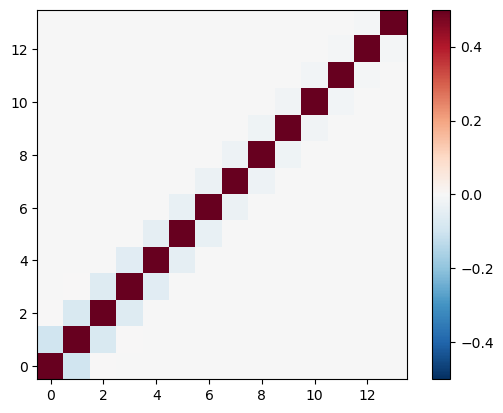

In [158]:
corrmat=np.zeros(covmat.shape)
for ii in range(14):
    for jj in range(14):
        corrmat[ii,jj]=covmat[ii,jj]/np.sqrt(covmat[ii,ii]*covmat[jj,jj])

pl.imshow(corrmat,origin='lower',vmax=0.5,vmin=-0.5,cmap='RdBu_r')
pl.colorbar()

In [185]:
print("chi sq uniform: ", chi_sq_1/len(vec))
print("chi sq vd: ", chi_sq_2/len(vec))

chi sq uniform:  [1.6435075  0.65711953 2.53910623 0.81653069 1.2837246  1.87382506
 1.10439869 1.68680749 0.68322391 2.12077205 1.23452329 1.00986168
 0.8700531  1.49252597 3.02378539]
chi sq vd:  [1.73124468 1.42123005 1.8926936  0.99512734 0.99106301 1.21191861
 1.17970896 0.76731326 0.67783997 1.57817377 1.78369407 1.25290539
 1.14592567 1.21137089 3.28530139]
